**<h3>1 Water pump prediction<h3>**

### 1.1 Library insertion

In [672]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

### 1.2 Data insertion and variable creation

In [808]:
training_data_value = pd.read_csv("Data/Training_set_values.csv")
training_data_label = pd.read_csv("Data/Training_set_labels.csv")
testing_data = pd.read_csv("Data/Test_set_values.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# merge data
ex_data_list = []
Merged_training_data = pd.merge(training_data_value,training_data_label, on="id")
All_data = pd.concat([testing_data, Merged_training_data])
All_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN
2,17168,0.0,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
3,45559,0.0,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN
4,49871,500.0,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


### 1.3 Support function

In [674]:
# support function for numerical data, for analysis whole dataframe
def numerical_analysis(dataFrame):
  
  # Only select numerical columns
  numerical = dataFrame.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
  
  #data type
  data_types = pd.DataFrame(dataFrame[numerical].dtypes,columns=['Data Type'])

  # number of data count
  count_val = pd.DataFrame(columns=['Count'])

  for row in list(dataFrame[numerical].columns.values):
      count_val.loc[row] = [dataFrame[numerical][row].count()]
    
  # missing data
  missing_data = pd.DataFrame(dataFrame[numerical].isnull().sum(),columns=['Missing Values'])

  # maximum value
  maximum_val = pd.DataFrame(columns=['Maximum'])

  for row in list(dataFrame[numerical].columns.values):
      maximum_val.loc[row] = [dataFrame[numerical][row].max()]
    
  # minimum value
  minimum_val = pd.DataFrame(columns=['Minimum'])

  for row in list(dataFrame[numerical].columns.values):
      minimum_val.loc[row] = [dataFrame[numerical][row].min()]
    
  # mean value
  mean_val= pd.DataFrame(columns=['Mean'])

  for row in list(dataFrame[numerical].columns.values):
      mean_val.loc[row] = [dataFrame[numerical][row].mean()]

  # standard deviation value
  sd_val = pd.DataFrame(columns=['Standard Deviation'])

  for row in list(dataFrame[numerical].columns.values):
      sd_val.loc[row] = [dataFrame[numerical][row].std()]

  # mode
  mode_val = pd.DataFrame(columns=['Mode'])

  for row in list(dataFrame[numerical].columns.values): 
    mode_val.loc[row] = [dataFrame[numerical][row].mode()[0]]
    mode_0 = mode_val.loc[row]
  
  # mode frequency
  count_f_list = []

  for row in numerical:
    mode_0 = dataFrame[row].mode().iat[0]
    count_f = dataFrame[row].value_counts()[mode_0]
    count_f_list.append(count_f)

  count_f_list = np.array(count_f_list)
    
  # First quartile
  IqR_1 = pd.DataFrame(columns=['1st Quartile'])

  for row in list(dataFrame[numerical].columns.values):
      IqR_1.loc[row] = [dataFrame[numerical][row].quantile(0.25)]
    
  # Median
  median = pd.DataFrame(columns=['Median'])

  for row in list(dataFrame[numerical].columns.values):
    median.loc[row] = [dataFrame[numerical][row].quantile(0.5)]
    
  # Third quartile
  IqR_3 = pd.DataFrame(columns=['3rd Quartile'])

  for row in list(dataFrame[numerical].columns.values):
    IqR_3.loc[row] = [dataFrame[numerical][row].quantile(0.75)]

  # Unique values
  unique_val = pd.DataFrame(columns=['Unique Values'])

  for row in list(dataFrame[numerical].columns.values):
    unique_val.loc[row] = [dataFrame[numerical][row].nunique()]
  
    
  # join columns 
  result = data_types.join(count_val).join(missing_data).join(unique_val).join(minimum_val).join(maximum_val).join(mean_val).join(sd_val).join(IqR_1).join(median).join(IqR_3).join(mode_val)
  
  # percentage missing
  result['Missing in %'] = (result['Missing Values'] / len(dataFrame[numerical]) *100)
  
  # alternative mode calculation
  result['Mode freq'] = count_f_list 
  result['Mode in %'] = (result['Mode freq'] / result['Count']*100).astype('float')


  # change order of columns
  result = result[['Data Type', 'Count', 'Missing Values', 'Missing in %','Unique Values', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode', 'Mode freq','Mode in %']]

  #round
  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum','Mode freq','Mode in %','Mode']] =  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode freq','Mode in %','Mode']].round(1)
  
   
  #rreturn report
  return(result)


In [675]:
num_analysis = numerical_analysis(All_data)
num_analysis

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
id,int64,74250,0,0.0,74250,37124.5,21434.3,0.0,18562.2,37124.5,55686.8,74249.0,0.0,1,0.0
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6
population,int64,74250,0,0.0,1128,180.8,471.1,0.0,0.0,25.0,215.0,30500.0,0.0,26834,36.1
construction_year,int64,74250,0,0.0,55,1298.5,952.3,0.0,0.0,1986.0,2004.0,2013.0,0.0,25969,35.0


In [676]:
def categorical_analysis(dataFrame):

    # Select categorical columns
    cat_columns = dataFrame.select_dtypes(include='object').columns.tolist()

    # Data types
    data_types = pd.DataFrame(dataFrame[cat_columns].dtypes,columns=['Data Type'])


    # Missing data
    missing_df = pd.DataFrame(dataFrame[cat_columns].isnull().sum(),columns=['Missing Values'])

    # Record counts
    records_df = pd.DataFrame(columns=['Records'])

    for col in list(dataFrame[cat_columns].columns.values):
        records_df.loc[col] = [dataFrame[cat_columns][col].count()]

    # Unique values
    unique_val = pd.DataFrame(columns=['Unique Values'])
    for col in list(dataFrame[cat_columns].columns.values):
        unique_val.loc[col] = [dataFrame[cat_columns][col].nunique()]

    # Mode
    mode_df = pd.DataFrame(columns=['Mode'])

    for col in list(dataFrame[cat_columns].columns.values):
        mode_df.loc[col] = [dataFrame[cat_columns][col].mode()[0]]

    # Mode frequency
    mode_freq_list = []
    for col in cat_columns:
        mode_val = dataFrame[col].mode().iat[0]
        freq = dataFrame[col].value_counts()[mode_val]
        mode_freq_list.append(freq)
    mode_freq_array = np.array(mode_freq_list)

    # Create data quality report
    result = data_types.join(missing_df).join(records_df).join(unique_val).join(mode_df)
    result['Mode freq'] = mode_freq_array
    result['Mode in %'] = (result['Mode freq'] / result['Records'] * 100).astype('float')
    result['Missing in %'] = (result['Missing Values'] / len(dataFrame[cat_columns]) * 100)

    # Change order of columns
    result = result[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing in %', 'Mode', 'Mode freq', 'Mode in %']]
    result[['Missing in %', 'Mode in %']] = result[['Missing in %', 'Mode in %']].round(1)

    # Return report
    return result

In [677]:
cat_analysis = categorical_analysis(All_data)
cat_analysis

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2
installer,object,69718,2410,4532,6.1,DWE,21751,31.2
wpt_name,object,74248,45683,2,0.0,none,4440,6.0
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9
region,object,74250,21,0,0.0,Iringa,6599,8.9
lga,object,74250,125,0,0.0,Njombe,3128,4.2
ward,object,74250,2098,0,0.0,Igosi,386,0.5
public_meeting,object,70095,2,4155,5.6,True,63749,90.9


In [678]:
# check duplicate 
def check_duplicate(dataFrame):
  duplicates = dataFrame.duplicated(keep = 'first').sum()
  print("No. duplicates: {}".format(duplicates))
  print("Total counts: {}".format(len(dataFrame)))
  print("Duplicated in %: {}".format((duplicates/len(dataFrame))*100))

In [679]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


In [680]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

**<h3>2 EDA - Preview<h3>**

**2.1 Duplication**

In [681]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


**<h3>3 EDA - Data Features<h3>**

### 3.1 Amount_tsh

In [682]:
num_analysis.loc[['amount_tsh']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1


In [683]:
All_data['amount_tsh'].isna().sum()

0

In [684]:
All_data['amount_tsh'] = All_data['amount_tsh'].replace(0,All_data['amount_tsh'].mean())

In [685]:
All_data['amount_tsh'].mode()

0    318.685704
Name: amount_tsh, dtype: float64

The most occured value is 0 and it was over 70% in whole data. We can assume that it contains some missing value.
It could be replaced by mean values or drop this feature after experiment.

### 3.2 date_recorded

In [686]:
cat_analysis.loc[['date_recorded']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8


From the first category analysis, there is no important insight we can gain from this form. To obtain further information, we can make a filter to only year or month.

### 3.2.1 recorded year

In [687]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_year'] = pd.DatetimeIndex(temp['date_recorded']).year

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_year')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_year,,,,,
2002,1.0,0.0,100.0,0.0,0.0
2004,30.0,0.1,33.3,63.3,3.3
2011,28674.0,48.3,56.6,37.1,6.3
2012,6424.0,10.8,48.7,45.7,5.6
2013,24271.0,40.9,53.2,38.0,8.8


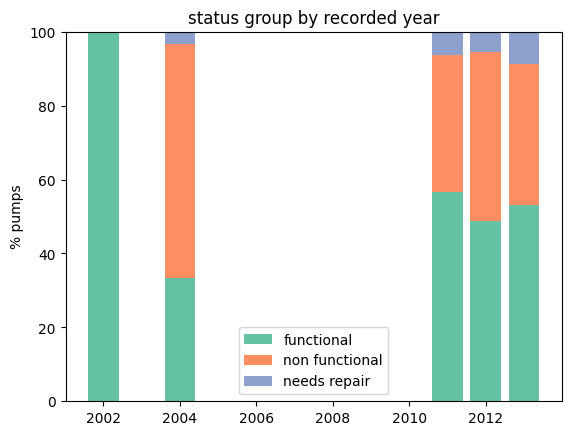

In [688]:
#plot status group by recorded year

fig, ax = plt.subplots()
labels = temp['recorded_year'].sort_values().unique()[1:]
ax.bar(labels, recorded['perc_functional'], label ='functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded year')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The majority data are focusing between 2011 to 2013. Which is have the most of the variuos status group data.

#### 3.2.2 Recorded month

In [689]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_month'] = pd.DatetimeIndex(temp['date_recorded']).month

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_month')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_month,,,,,
1,6354.0,10.7,41.1,46.2,12.7
2,12402.0,20.9,55.2,37.3,7.5
3,17936.0,30.2,61.7,33.3,5.0
4,3970.0,6.7,51.6,37.3,11.0
5,336.0,0.6,60.1,36.9,3.0
6,346.0,0.6,78.0,19.4,2.6
7,6928.0,11.7,50.2,41.9,7.9
8,3364.0,5.7,51.1,41.4,7.5
9,328.0,0.6,65.2,31.7,3.0


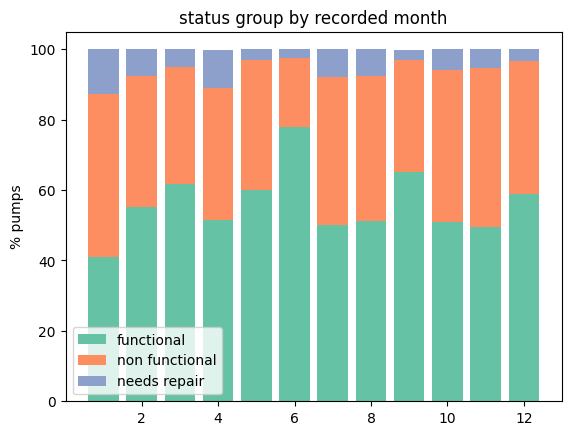

In [690]:
#plot status group by 'recorded_month'
fig, ax = plt.subplots()
labels = temp['recorded_month'].sort_values().unique()
ax.bar(labels, recorded['perc_functional'], label = 'functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded month')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The status of most pumps recorded is in February and March and far less in May and June. The data showing a trend that with less recorded month which will contain less needs repair pump.

It seems that the functionality rates of pumps vary across different months, though this observation could be influenced by the fewer data entries recorded during these periods.

In conclusion, we may replace construction month rather than construction year because it is containing a bit more detail. We can use weather condition to category all month into 4 weather condition.

In [691]:
All_data['month'] = pd.DatetimeIndex(All_data['date_recorded']).month

# season encoder
season_mapper = {1: 'Winter',2:'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',6: 'Summer', 
                 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11:'Autumn', 12:'Winter'}
#.p feature values to scale
All_data['season']=All_data['month'].replace(season_mapper)
All_data=All_data.drop('month', axis=1)

In [692]:
All_data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.000000,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Spring
59396,27263,4700.000000,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,Spring
59397,37057,318.685704,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,Spring
59398,31282,318.685704,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,Spring


In [693]:
All_data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.000000,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Spring
59396,27263,4700.000000,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,Spring
59397,37057,318.685704,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,Spring
59398,31282,318.685704,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,Spring


### 3.3 funder

In [694]:
cat_analysis.loc[['funder']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2


In [695]:
funder = distribution_checker(All_data, 'funder')
funder = funder.sort_values('nr_pumps', ascending= False)
funder.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
funder,,,,,
Government Of Tanzania,9084.0,16.3,41.0,51.3,7.7
Danida,3114.0,5.6,55.0,39.9,5.1
Hesawa,2202.0,3.9,42.5,47.0,10.5
Rwssp,1374.0,2.5,58.6,33.5,7.9
World Bank,1349.0,2.4,40.4,52.4,7.2
Kkkt,1287.0,2.3,56.2,38.7,5.1
World Vision,1246.0,2.2,59.6,29.9,10.5
Unicef,1057.0,1.9,56.8,33.9,9.4
Tasaf,877.0,1.6,56.2,36.5,7.3


Funder has over 2000 unique categories. The Government of Tanzania is with 16% the most common funder.  Just by looking at the top 10 most common funders we can see the 'status_group' distribution differs. I therefore think 'funder' could be an interessting column to include in a model, but we have to find a suitable way to encode it without increasing the dimensionality of the dataframe too much. 

In [696]:
All_data['funder'] = All_data['funder'].fillna(All_data['installer'].mode().to_list()[0])

In [697]:
All_data['funder'].isna().sum()

0

### 3.4 installer


In [698]:
cat_analysis.loc[['installer']]


,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
installer,object,69718,2410,4532,6.1,DWE,21751,31.2


In [699]:
All_data['installer'].isna().sum()

4532

In [700]:
#check the distribution of status groups for the 10 most frequent installer
installer = distribution_checker(All_data, 'installer')
installer = installer.sort_values('nr_pumps', ascending= False)
installer.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
installer,,,,,
DWE,17402.0,31.2,54.2,36.5,9.3
Government,1825.0,3.3,29.3,56.7,14.0
RWE,1206.0,2.2,25.2,63.4,11.4
Commu,1060.0,1.9,68.3,28.7,3.0
DANIDA,1050.0,1.9,51.6,40.5,7.9
KKKT,898.0,1.6,47.0,46.1,6.9
Hesawa,840.0,1.5,56.5,41.4,2.0
0,777.0,1.4,57.3,42.3,0.4
TCRS,707.0,1.3,41.0,53.0,5.9


Installer has like funder a very high cardinality. DWE is by far the most common installer. Again we see differences in the distribution of 'status_group' in the top 10 installers. Installer could be an interessting feature, but it has to be encoded properly to avoid increasing the dimensionality of the dataset.

In [701]:
All_data['installer'].mode().to_list()[0]

'DWE'

In [702]:
All_data['installer'] = All_data['installer'].fillna(All_data['installer'].mode().to_list()[0])

In [703]:
All_data['installer'].isna().sum()

0

In [704]:
min_val = installer['nr_pumps'].min()
max_val = installer['nr_pumps'].max()
installer['installer_share'] = (installer['nr_pumps'] - min_val) / (max_val - min_val)
installer_share = installer['installer_share'].to_dict()

All_data['installer'] = All_data['installer'].map(installer_share)
All_data['installer'] 
#print()

0        0.005057
1        1.000000
2        1.000000
3        0.001839
4        0.000862
           ...   
59395    0.034998
59396    0.000805
59397    1.000000
59398    0.000230
59399    0.006896
Name: installer, Length: 74250, dtype: float64

Installer will be replaced by grouped by number of pumps data, and the value will be normalized to show the share over all installer.

### 3.5 GPS height

In [705]:
num_analysis.loc[['gps_height']]


,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5


In [706]:
All_data['gps_height']

0        1996
1        1569
2        1567
3         267
4        1260
         ... 
59395    1210
59396    1212
59397       0
59398       0
59399     191
Name: gps_height, Length: 74250, dtype: int64

/var/folders/zg/3w16yt6n5g9bvlyjkyzc5k3r0000gn/T/ipykernel_71906/1996353301.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')


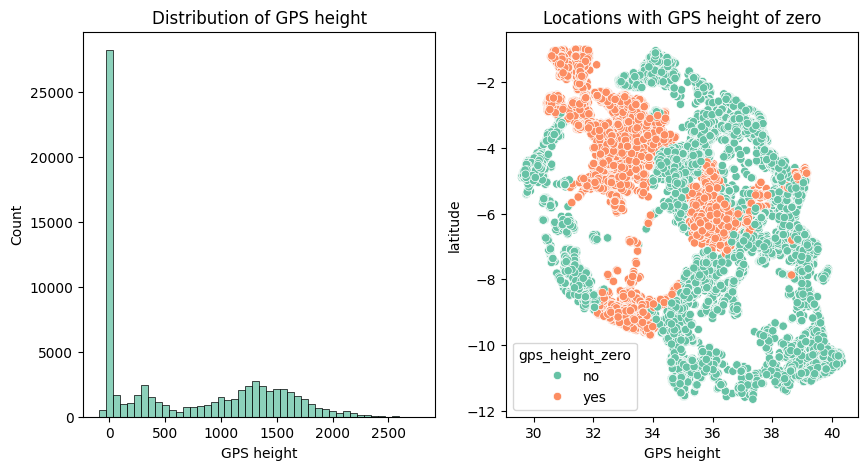

In [707]:
fig, axes = plt.subplots(1, 2,  figsize=(10,5))

#plot distribution of gps height
sns.histplot( All_data[ 'gps_height'], color = '#66c2a5', ax=axes[0])
axes[0].set(title = 'Distribution of GPS height', xlabel = 'GPS height')

#plot locations where gps height is zero
temp = All_data[All_data['longitude']!=0]  #only include records where logitude isn't zero
temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')
sns.scatterplot(x= temp['longitude'], y = temp['latitude'], hue = temp['gps_height_zero'], palette='Set2', ax = axes[1])
axes[1].set(title = 'Locations with GPS height of zero', xlabel = 'GPS height')

plt.show()

Tanzania is not situated below sea level; therefore, any negative readings for GPS height are incorrect. Typically, the GPS altitude error margin is approximately ± 15 meters, which is accurate 95% of the time. During the remaining 5%, the altitude could register any value. It is unclear whether the GPS height refers to the water level height or the well location. What is evident, however, is that most places recording a GPS height of zero are not at sea level. From this, I infer that zero is often used to denote missing data in GPS height recordings.

The data did not represent any interest trend, so this time we can try to drop it and let's see how the result showing us. 

In [708]:
All_data = All_data.drop(columns='gps_height')

In [709]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,36.656709,-3.309214,Kimnyak,0,Pangani,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,34.767863,-5.004344,Puma Secondary,0,Internal,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.6 Longitude

In [710]:
num_analysis.loc[['longitude']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1


A longitude of zero does not exist for Tanzania. Missing values are imputed as zero.

In [711]:
All_data = All_data.drop(columns='longitude')

In [712]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,latitude,wpt_name,num_private,basin,subvillage,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,-4.059696,Dinamu Secondary School,0,Internal,Magoma,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,-3.309214,Kimnyak,0,Pangani,Kimnyak,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,-5.004344,Puma Secondary,0,Internal,Msatu,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.7 Latitude

In [713]:
num_analysis.loc[['latitude']]


,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1


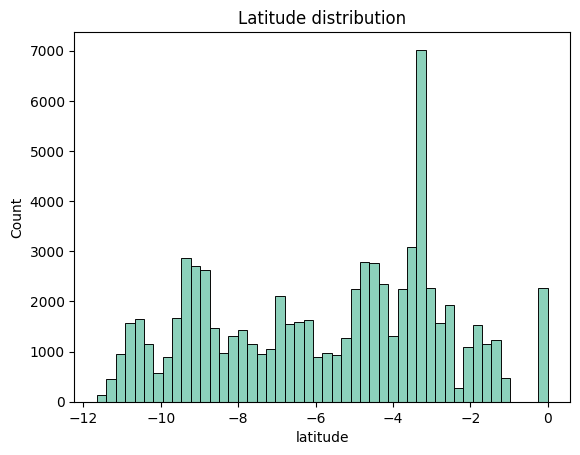

In [714]:
#distribution of latitude
ax = sns.histplot( All_data[ 'latitude'], color = '#66c2a5')
ax.set(title = 'Latitude distribution')
plt.show()

From the data quality report the presense of zero is not immediately clear, but after plotting we can see that latitudes with a value of zero are indeed present. These represent missing values and need to be imputed properly.

In [715]:
All_data = All_data.drop(columns='latitude')

In [716]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,wpt_name,num_private,basin,subvillage,region,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Dinamu Secondary School,0,Internal,Magoma,Manyara,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,0,Pangani,Kimnyak,Arusha,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,Puma Secondary,0,Internal,Msatu,Singida,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.8 Wpt Name

In [717]:
cat_analysis.loc[['wpt_name']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
wpt_name,object,74248,45683,2,0.0,none,4440,6.0


In [718]:
#check the distribution of status groups for the 10 most frequent namesb
name = distribution_checker(All_data, 'wpt_name')
name= name.sort_values('nr_pumps', ascending= False)
name.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
wpt_name,,,,,
none,3563.0,6.0,73.8,24.1,2.1
Shuleni,1748.0,2.9,49.1,42.7,8.2
Zahanati,830.0,1.4,51.8,38.8,9.4
Msikitini,535.0,0.9,49.2,42.6,8.2
Kanisani,323.0,0.5,48.0,45.5,6.5
Bombani,271.0,0.5,58.3,33.9,7.7
Sokoni,260.0,0.4,46.2,43.8,10.0
Ofisini,254.0,0.4,43.3,52.4,4.3
School,208.0,0.4,41.8,51.9,6.2


Waterpoint name has an extremely high cardinality. The most common name is 'None', indicating that the pump has no name. As expected, the name of the waterpump appears to have no relationship with the status of the pump. This is a feature that we can drop later.

In [719]:
All_data = All_data.drop(columns='wpt_name')

In [720]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,num_private,basin,subvillage,region,region_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,0,Internal,Magoma,Manyara,21,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,0,Pangani,Kimnyak,Arusha,2,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,0,Internal,Msatu,Singida,13,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.9 Num private


In [721]:
num_analysis.loc[['num_private']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7



It is immediately clear that this feature will hold little information as 98.7% of the records consists of the value zero. This is a good candidate to drop from later analysis.

In [722]:
All_data = All_data.drop(columns='num_private')

In [723]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,basin,subvillage,region,region_code,district_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Internal,Magoma,Manyara,21,3,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Pangani,Kimnyak,Arusha,2,2,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,Internal,Msatu,Singida,13,2,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.10 Basin

In [724]:
cat_analysis.loc[['basin']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3


In [725]:
basin = distribution_checker(All_data, 'basin')
basin = basin.sort_values('nr_pumps', ascending= False)
basin.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
basin,,,,,
Lake Victoria,10248.0,17.3,49.8,40.6,9.7
Pangani,8940.0,15.1,60.1,34.6,5.3
Rufiji,7976.0,13.4,63.5,31.0,5.5
Internal,7785.0,13.1,57.6,35.3,7.2
Lake Tanganyika,6432.0,10.8,48.3,40.2,11.5
Wami / Ruvu,5987.0,10.1,52.4,43.1,4.5
Lake Nyasa,5085.0,8.6,65.4,29.7,4.9
Ruvuma / Southern Coast,4493.0,7.6,37.2,55.6,7.3
Lake Rukwa,2454.0,4.1,40.7,48.2,11.0


The distribution of pumps over the different basins if fairly equal. We previously saw that certain regions have much more functional or non-functional pumps. It is therefore not surprising that certain basins also have more or less functional pumps. 

In [726]:
tem_basin = pd.get_dummies(All_data['basin'],dtype='int_')
All_data = pd.concat([All_data, tem_basin], axis=1)


All_data = All_data.drop(columns='basin')
All_data

,id,amount_tsh,date_recorded,funder,installer,subvillage,region,region_code,district_code,lga,...,season,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Magoma,Manyara,21,3,Mbulu,...,Spring,1,0,0,0,0,0,0,0,0
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,Arusha,2,2,Arusha Rural,...,Spring,0,0,0,0,0,1,0,0,0
2,17168,318.685704,1/2/2013,DWE,1.000000,Msatu,Singida,13,2,Singida Rural,...,Winter,1,0,0,0,0,0,0,0,0
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Kipindimbi,Lindi,80,43,Liwale,...,Winter,0,0,0,0,0,0,0,1,0
4,49871,500.000000,27/3/2013,Bruder,0.000862,Losonga,Ruvuma,10,3,Mbinga,...,Spring,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.000000,2013-05-03,Germany Republi,0.034998,Kiduruni,Kilimanjaro,3,5,Hai,...,Spring,0,0,0,0,0,1,0,0,0
59396,27263,4700.000000,2011-05-07,Cefa-njombe,0.000805,Igumbilo,Iringa,11,4,Njombe,...,Spring,0,0,0,0,0,0,1,0,0
59397,37057,318.685704,2011-04-11,DWE,1.000000,Madungulu,Mbeya,12,7,Mbarali,...,Spring,0,0,0,0,0,0,1,0,0
59398,31282,318.685704,2011-03-08,Malec,0.000230,Mwinyi,Dodoma,1,4,Chamwino,...,Spring,0,0,0,0,0,0,1,0,0


### 3.11 Region

In [727]:
cat_analysis.loc[['region']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
region,object,74250,21,0,0.0,Iringa,6599,8.9


In [728]:
region = distribution_checker(All_data, 'region')
region = region.sort_values('nr_pumps', ascending= False)
region.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region,,,,,
Iringa,5294.0,8.9,78.2,19.5,2.3
Shinyanga,4982.0,8.4,56.0,31.3,12.7
Mbeya,4639.0,7.8,50.0,39.1,10.9
Kilimanjaro,4379.0,7.4,60.3,32.4,7.4
Morogoro,4006.0,6.7,52.9,39.6,7.5
Arusha,3350.0,5.6,68.5,26.3,5.2
Kagera,3316.0,5.6,52.1,38.8,9.2
Mwanza,3102.0,5.2,48.4,45.7,5.9
Kigoma,2816.0,4.7,48.4,30.2,21.4


Tanzania has 21 different regions and from the table above we can already see that certain regions have a much higher proportion of functional pumps than other regions. The location of the pumps is therefore relevant.

### 3.12 Region code (need to do nor)

In [729]:
num_analysis.loc[['region_code']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9


In [730]:
#group region_codes by region
region_code = All_data.groupby(['region','region_code',])['id'].count().reset_index()
region_code.head(10)

,region,region_code,id
0,Arusha,2,3709
1,Arusha,24,402
2,Dar es Salaam,7,1020
3,Dodoma,1,2779
4,Iringa,11,6599
5,Kagera,18,4174
6,Kigoma,16,3533
7,Kilimanjaro,3,5494
8,Lindi,8,375
9,Lindi,18,9


In [731]:
#check distribution of status group by region code
region_code = distribution_checker(All_data, 'region_code')
region_code = region_code.sort_values('nr_pumps', ascending= False)
region_code.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region_code,,,,,
11,5300.0,8.9,78.2,19.5,2.3
17,5011.0,8.4,56.0,31.3,12.7
12,4639.0,7.8,50.0,39.1,10.9
3,4379.0,7.4,60.3,32.4,7.4
5,4040.0,6.8,53.1,39.4,7.4
18,3324.0,5.6,52.0,38.8,9.1
19,3047.0,5.1,48.2,46.0,5.8
2,3024.0,5.1,65.4,28.8,5.8
16,2816.0,4.7,48.4,30.2,21.4


Tanzania has 21 different regions, but 27 different region_codes. This means that the regio_code feature contains slightly more information that the region feature. It must be said that some of the region_code categories contain only a few pumps. The region Arusha has 68.5% functional pumps. When we look at the region_codes within Arusha, we see that this percentage varies between 65 and 97%. This is a big and interessting difference!

### 3.13 District code

In [732]:
num_analysis.loc[['district_code']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6


In [733]:
#group region_codes by region
district_code = All_data.groupby([  'region', 'district_code',])['id'].count().reset_index()
district_code.head(10)

,region,district_code,id
0,Arusha,1,226
1,Arusha,2,1460
2,Arusha,3,143
3,Arusha,5,245
4,Arusha,6,391
5,Arusha,7,1244
6,Arusha,30,402
7,Dar es Salaam,1,121
8,Dar es Salaam,2,633
9,Dar es Salaam,3,266


Tanzania has 20 different district numbers, but it appears that these districts are relevant in the region context. So both Arusha and Dar es Salaam have a district 1. It might be interesting to create a region-district feature to capture this information.

### 3.14 Lga

In [734]:
cat_analysis.loc[['lga']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
lga,object,74250,125,0,0.0,Njombe,3128,4.2


In [735]:
#group lga by region
lga = All_data.groupby([  'region', 'lga',])['id'].count().reset_index()
lga.head(10)

,region,lga,id
0,Arusha,Arusha Rural,1521
1,Arusha,Arusha Urban,82
2,Arusha,Karatu,402
3,Arusha,Longido,391
4,Arusha,Meru,1244
5,Arusha,Monduli,226
6,Arusha,Ngorongoro,245
7,Dar es Salaam,Ilala,633
8,Dar es Salaam,Kinondoni,121
9,Dar es Salaam,Temeke,266


A region consists of different lga's. There are 125 different lga's, which is a bit too much to encode in a model, but it could be an useful feature for imputing missing geospatial data.

### 3.15 Ward

In [736]:
cat_analysis.loc[['ward']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
ward,object,74250,2098,0,0.0,Igosi,386,0.5


In [737]:
#group ward by lga
ward = All_data.groupby([  'lga', 'ward'])['id'].count().reset_index()
ward.head(10)

,lga,ward,id
0,Arusha Rural,Bangata,43
1,Arusha Rural,Bwawani,46
2,Arusha Rural,Ilkiding'a,104
3,Arusha Rural,Kimnyaki,93
4,Arusha Rural,Kiranyi,139
5,Arusha Rural,Kisongo,37
6,Arusha Rural,Mateves,28
7,Arusha Rural,Mlangarini,111
8,Arusha Rural,Moivo,52
9,Arusha Rural,Moshono,57


A lga can be further divided into different wards. A total of 2098 wards can be found in the dataset. Because of the high cardinality we cannot use this feature in a model, but it is useful for imputing purposes.

### 3.16 Subvillage

In [738]:
cat_analysis.loc[['subvillage']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9


In [739]:
#group ward by lga
village= All_data.groupby(['lga', 'ward', 'subvillage'])['id'].count().reset_index()
village.head(10)

,lga,ward,subvillage,id
0,Arusha Rural,Bangata,Engikaleti,23
1,Arusha Rural,Bangata,Gwasei,2
2,Arusha Rural,Bangata,Kwaniche,5
3,Arusha Rural,Bangata,Lobolosi,1
4,Arusha Rural,Bangata,Melenyi,1
5,Arusha Rural,Bangata,Ndukenyi,2
6,Arusha Rural,Bangata,Ngwasei,3
7,Arusha Rural,Bangata,Sanganani,5
8,Arusha Rural,Bangata,Sangananu,1
9,Arusha Rural,Bwawani,Buluga,2


Wards can be further divided into subvillages. The dataset contains over 20.000 subvillage. Most subvillages contain only 1 or a few pumps. This feature can be useful for imputing missing geospatial data.


#### This part is for conditional data handling, it will adding different dataframe into ex_data_list for further experiment

In [809]:
All_data.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


In [ ]:
con_1 = All_data.drop(columns='subvillage')
ex_data_list.append(con_1)

con_2 = All_data.drop(['lga', 'ward','district_code'], axis=1)
ex_data_list.append(con_2)

**3.1 scheme_management**

In [740]:
cat_analysis.loc[['scheme_management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
scheme_management,object,69403,11,4847,6.5,VWC,45917,66.2


In [741]:
All_data['scheme_management'].isna().sum()

4847

In [742]:
# Fill Nan with 'Unknown'
All_data = All_data.fillna({'scheme_management': 'Unknown'})

In [743]:
All_data['scheme_management'].isna().sum()

0

**3.2 management**

In [744]:
cat_analysis.loc[['management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management,object,74250,12,0,0.0,vwc,50624,68.2


In [745]:
All_data['management'].isna().sum()

0

**3.3 management_group**

In [746]:
cat_analysis.loc[['management_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management_group,object,74250,5,0,0.0,user-group,65538,88.3


In [747]:
All_data['management_group'].isna().sum()

0

**3.4 payment**

In [748]:
cat_analysis.loc[['payment']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment,object,74250,7,0,0.0,never pay,31712,42.7


In [749]:
print(All_data['payment'].value_counts())

payment
never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: count, dtype: int64


**3.5 payment_type**

In [750]:
cat_analysis.loc[['payment_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment_type,object,74250,7,0,0.0,never pay,31712,42.7


In [751]:
print(All_data['payment_type'].value_counts())

payment_type
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: count, dtype: int64


In [752]:
# Map 'payment' values to 'payment_type' values
replacement_map = {
    'pay per bucket': 'per bucket',
    'pay monthly': 'monthly',
    'pay annually': 'annually',
    'never pay': 'never pay',
    'unknown': 'unknown',
    'pay when scheme fails': 'on failure',
    'other': 'other'
}

All_data['payment_standardized'] = All_data['payment'].replace(replacement_map)

In [753]:
# Check if the standardized payment column is the same as payment_type
All_data['comparison'] = All_data['payment_standardized'] == All_data['payment_type']
all_identical = All_data['comparison'].all()

print(f"All values identical: {all_identical}")

All values identical: True


**payment** and **payment_type** have the same values, so drop one of them. Here I drop the **payment** column.

In [754]:
 # Drop the original 'payment' column
All_data.drop(columns=['payment'], inplace=True)
All_data.drop(columns=['payment_standardized'], inplace=True)
All_data.drop(columns=['comparison'], inplace=True)

In [755]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['payment_type'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  installer  \
0  50785  318.685704      4/2/2013                    Dmdd   0.005057   
1  51630  318.685704      4/2/2013  Government Of Tanzania   1.000000   
2  17168  318.685704      1/2/2013                     DWE   1.000000   
3  45559  318.685704     22/1/2013              Finn Water   0.001839   
4  49871  500.000000     27/3/2013                  Bruder   0.000862   

   subvillage   region  region_code  district_code            lga  ... Rufiji  \
0      Magoma  Manyara           21              3          Mbulu  ...      0   
1     Kimnyak   Arusha            2              2   Arusha Rural  ...      0   
2       Msatu  Singida           13              2  Singida Rural  ...      0   
3  Kipindimbi    Lindi           80             43         Liwale  ...      0   
4     Losonga   Ruvuma           10              3         Mbinga  ...      0   

   Ruvuma / Southern Coast Wami / Ruvu payment_type_annually  \
0         

In [756]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'installer',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group', 'season',
       'Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_other', 'payment_type_per bucket',
       'payment_type_unknown'],
      dtype='object')


In [757]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'payment_type_annually')
calculate_zero_percentage(All_data, 'payment_type_monthly')
calculate_zero_percentage(All_data, 'payment_type_never pay')
calculate_zero_percentage(All_data, 'payment_type_on failure')
calculate_zero_percentage(All_data, 'payment_type_other')
calculate_zero_percentage(All_data, 'payment_type_per bucket')
calculate_zero_percentage(All_data, 'payment_type_unknown')

Percentage of 0s for payment_type_annually: 93.85%
Percentage of 0s for payment_type_monthly: 86.00%
Percentage of 0s for payment_type_never pay: 57.29%
Percentage of 0s for payment_type_on failure: 93.48%
Percentage of 0s for payment_type_other: 98.23%
Percentage of 0s for payment_type_per bucket: 84.83%
Percentage of 0s for payment_type_unknown: 86.33%


In [758]:
# Drop the 'payment_type_other'
All_data.drop(columns=['payment_type_other'], inplace=True)

In [759]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'installer',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group', 'season',
       'Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown'],
      dtype='object')


**3.6 water_quality**

In [760]:
cat_analysis.loc[['water_quality']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
water_quality,object,74250,8,0,0.0,soft,63505,85.5


In [761]:
print(All_data['water_quality'].value_counts())

water_quality
soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: count, dtype: int64


**3.7 quality_group**

In [762]:
cat_analysis.loc[['quality_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quality_group,object,74250,6,0,0.0,good,63505,85.5


In [763]:
print(All_data['quality_group'].value_counts())

quality_group
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: count, dtype: int64


In [764]:
# Check mapping from water_quality to quality_group
mapping_check = All_data.groupby(['water_quality', 'quality_group']).size().reset_index(name='Count')
print(mapping_check)

        water_quality quality_group  Count
0            coloured       colored    623
1            fluoride      fluoride    244
2  fluoride abandoned      fluoride     23
3               milky         milky   1005
4               salty         salty   6082
5     salty abandoned         salty    423
6                soft          good  63505
7             unknown       unknown   2345


The relationship between `water_quality` and `quality_group` seems straightforward. Each `water_quality` corresponds to a specific `quality_group`, suggesting that `quality_group` is a more general classification of `water_quality`.

- **`water_quality`** has more subdivisions, including specific water quality descriptions such as fluoride (containing fluoride) and fluoride abandoned (abandoned containing fluoride). 
- **`quality_group`** provides a more simplified view, merging some subdivisions (such as classifying both fluoride and fluoride abandoned as fluoride). 

- If we choose to keep the more detailed `water_quality`, we may need to do some additional data processing, such as handling very rare categories or considering how to handle unknown categories. 
- If we choose to keep `quality_group`, we can reduce variables in the model to avoid overfitting and may improve processing speed and model generalization.

So we tend to keep the `quality_group`

**See visualiztion in next part**

**3.8 quantity**

In [765]:
cat_analysis.loc[['quantity']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity,object,74250,5,0,0.0,enough,41522,55.9


In [766]:
print(All_data['quantity'].value_counts())

quantity
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


**3.9 quantity_group**

In [767]:
cat_analysis.loc[['quantity_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity_group,object,74250,5,0,0.0,enough,41522,55.9


In [768]:
print(All_data['quantity_group'].value_counts())

quantity_group
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


In [769]:
same_values = (All_data['quantity'] == All_data['quantity_group']).all()
print("They have the same value：", same_values)

They have the same value： True


In [770]:
# Drop 'quantity_group' colunm
All_data.drop(columns=['quantity_group'], inplace=True)

In [771]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quantity'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  installer  \
0  50785  318.685704      4/2/2013                    Dmdd   0.005057   
1  51630  318.685704      4/2/2013  Government Of Tanzania   1.000000   
2  17168  318.685704      1/2/2013                     DWE   1.000000   
3  45559  318.685704     22/1/2013              Finn Water   0.001839   
4  49871  500.000000     27/3/2013                  Bruder   0.000862   

   subvillage   region  region_code  district_code            lga  ...  \
0      Magoma  Manyara           21              3          Mbulu  ...   
1     Kimnyak   Arusha            2              2   Arusha Rural  ...   
2       Msatu  Singida           13              2  Singida Rural  ...   
3  Kipindimbi    Lindi           80             43         Liwale  ...   
4     Losonga   Ruvuma           10              3         Mbinga  ...   

  payment_type_monthly  payment_type_never pay payment_type_on failure  \
0                    0                    

In [772]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'installer',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'water_quality', 'quality_group', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'season', 'Internal',
       'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika', 'Lake Victoria',
       'Pangani', 'Rufiji', 'Ruvuma / Southern Coast', 'Wami / Ruvu',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quantity_dry',
       'quantity_enough', 'quantity_insufficient', 'quantity_seasonal',
       'quantity_unknown'],
      dt

In [773]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'quantity_dry')
calculate_zero_percentage(All_data, 'quantity_enough')
calculate_zero_percentage(All_data, 'quantity_insufficient')
calculate_zero_percentage(All_data, 'quantity_seasonal')
calculate_zero_percentage(All_data, 'quantity_unknown')

Percentage of 0s for quantity_dry: 89.52%
Percentage of 0s for quantity_enough: 44.08%
Percentage of 0s for quantity_insufficient: 74.55%
Percentage of 0s for quantity_seasonal: 93.16%
Percentage of 0s for quantity_unknown: 98.69%


**3.10 source**

In [774]:
cat_analysis.loc[['source']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source,object,74250,10,0,0.0,spring,21216,28.6


In [775]:
print(All_data['source'].value_counts())

source
spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: count, dtype: int64


**3.11 source_type**

In [776]:
cat_analysis.loc[['source_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_type,object,74250,7,0,0.0,spring,21216,28.6


In [777]:
print(All_data['source_type'].value_counts())

source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: count, dtype: int64


In [778]:
# Check mapping from source to source_type
mapping_check_source = All_data.groupby(['source', 'source_type']).size().reset_index(name='Count')
print(mapping_check_source)

                 source           source_type  Count
0                   dam                   dam    840
1              hand dtw              borehole   1108
2                  lake            river/lake    950
3           machine dbh              borehole  13822
4                 other                 other    261
5  rainwater harvesting  rainwater harvesting   2863
6                 river            river/lake  11964
7          shallow well          shallow well  21140
8                spring                spring  21216
9               unknown                 other     86


**3.12 source_class**

In [779]:
cat_analysis.loc[['source_class']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_class,object,74250,3,0,0.0,groundwater,57286,77.2


In [780]:
print(All_data['source_class'].value_counts())

source_class
groundwater    57286
surface        16617
unknown          347
Name: count, dtype: int64


**3.13 waterpoint_type**

In [781]:
cat_analysis.loc[['waterpoint_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type,object,74250,7,0,0.0,communal standpipe,35628,48.0


In [782]:
print(All_data['waterpoint_type'].value_counts())

waterpoint_type
communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: count, dtype: int64


**3.14 waterpoint_type_group**

In [783]:
cat_analysis.loc[['waterpoint_type_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type_group,object,74250,6,0,0.0,communal standpipe,43239,58.2


In [784]:
print(All_data['waterpoint_type_group'].value_counts())

waterpoint_type_group
communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: count, dtype: int64


In [785]:
# Check mapping from waterpoint_type to waterpoint_type_group
mapping_check_waterpoint = All_data.groupby(['waterpoint_type', 'waterpoint_type_group']).size().reset_index(name='Count')
print(mapping_check_waterpoint)

               waterpoint_type waterpoint_type_group  Count
0                cattle trough         cattle trough    150
1           communal standpipe    communal standpipe  35628
2  communal standpipe multiple    communal standpipe   7611
3                          dam                   dam      8
4                    hand pump             hand pump  21884
5              improved spring       improved spring    959
6                        other                 other   8010


### 3.17 population

In [786]:
# replace the missing values with median
All_data['population'] = All_data['population'].replace(0,All_data['population'].median())
All_data['population'] = All_data['population'].replace(1,All_data['population'].median())

# replace the missing values with mean
All_data_2 = All_data.copy()
All_data_2['population'] = All_data_2['population'].replace(0,All_data_2['population'].mean())
All_data_2['population'] = All_data_2['population'].replace(1,All_data_2['population'].mean())

In [787]:
All_data['population'] = (All_data['population']-All_data['population'].mean())/(All_data['population'].std())
All_data_2['population'] = (All_data_2['population']-All_data_2['population'].mean())/(All_data_2['population'].std())

### 3.18 public_meeting

In [788]:
All_data['public_meeting'].isna().sum()

4155

In [789]:
All_data['public_meeting'] = All_data['public_meeting'].replace(True, 1)
All_data['public_meeting'] = All_data['public_meeting'].replace(False, 0)

/var/folders/zg/3w16yt6n5g9bvlyjkyzc5k3r0000gn/T/ipykernel_71906/3293865861.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  All_data['public_meeting'] = All_data['public_meeting'].replace(False, 0)


In [790]:
print((All_data['public_meeting'] == 1).sum())
print((All_data['public_meeting'] == 0).sum())

63749
6346


We decided to replace missing value with mode value of public meeting which is 1.

In [791]:
All_data['public_meeting'] = All_data['public_meeting'].replace(np.nan, 1)

### 3.19 recorded_by

In [792]:
All_data['recorded_by'].unique()

array(['GeoData Consultants Ltd'], dtype=object)

The 'recorded_by' column has only one attribute which is GeoData Consultants Ltd. So we assumed that it is not an important data and decided to drop this column.

In [793]:
All_data = All_data.drop(['recorded_by'], axis=1)

### 3.20 scheme_name

In [794]:
All_data['scheme_name'].isna().sum()

36052

The missing value is 48.5% in this data. And it can be grouped into 'management' so we decided to drop this column.

In [795]:
All_data = All_data.drop(['scheme_name'], axis=1)

### 3.21 permit

In [796]:
All_data['permit'] = All_data['permit'].replace(True, 1)
All_data['permit'] = All_data['permit'].replace(False, 0)

/var/folders/zg/3w16yt6n5g9bvlyjkyzc5k3r0000gn/T/ipykernel_71906/474322896.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  All_data['permit'] = All_data['permit'].replace(False, 0)


In [797]:
print((All_data['permit'] == 1).sum())
print((All_data['permit'] == 0).sum())

48606
21851


We decided to replace missing value with mode value of permit which is 1.

In [798]:
All_data['permit'] = All_data['permit'].replace(np.nan, 1)

### 3.22 construction_year

In [799]:
# Replace the missing data with mode, mean or median and divide the construction_year to 6 categories
All_data['construction_year'] = All_data['construction_year'].replace(0, All_data['construction_year'].mean())

All_data_3 = All_data.copy()
All_data_3['construction_year'] = All_data_3['construction_year'].replace(0, All_data_3['construction_year'].median())

def categorize_year(year):
    if 1960 <= year <1970:
        return '60s'
    elif 1970 <= year <1980:
        return '70s'
    elif 1980 <= year <1990:
        return'80s'
    elif 1990 <= year <2000:
        return'90s'
    elif 2000 <= year <2010:
        return '00s'
    elif 2010 <= year <2020:
        return '10s'
    
All_data['construction_year'] = All_data['construction_year'].apply(categorize_year)
All_data_3['construction_year'] = All_data_3['construction_year'].apply(categorize_year)

In [800]:
# Do one hot encoding
one_hot_encoded_data = pd.get_dummies(All_data['construction_year'], dtype='int_')
All_data = pd.concat([All_data, one_hot_encoded_data],axis=1)

All_data.head()

one_hot_encoded_data = pd.get_dummies(All_data_3['construction_year'], dtype='int_')
All_data_3 = pd.concat([All_data_3, one_hot_encoded_data],axis=1)

All_data_3.head()

,id,amount_tsh,date_recorded,funder,installer,subvillage,region,region_code,district_code,lga,...,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,00s,10s,60s,70s,80s,90s
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Magoma,Manyara,21,3,Mbulu,...,0,0,1,0,0,1,0,0,0,0
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,Arusha,2,2,Arusha Rural,...,0,1,0,0,1,0,0,0,0,0
2,17168,318.685704,1/2/2013,DWE,1.000000,Msatu,Singida,13,2,Singida Rural,...,0,1,0,0,0,1,0,0,0,0
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Kipindimbi,Lindi,80,43,Liwale,...,0,0,0,0,0,0,0,0,1,0
4,49871,500.000000,27/3/2013,Bruder,0.000862,Losonga,Ruvuma,10,3,Mbinga,...,1,0,0,0,1,0,0,0,0,0


### 3.23 extraction_type_group

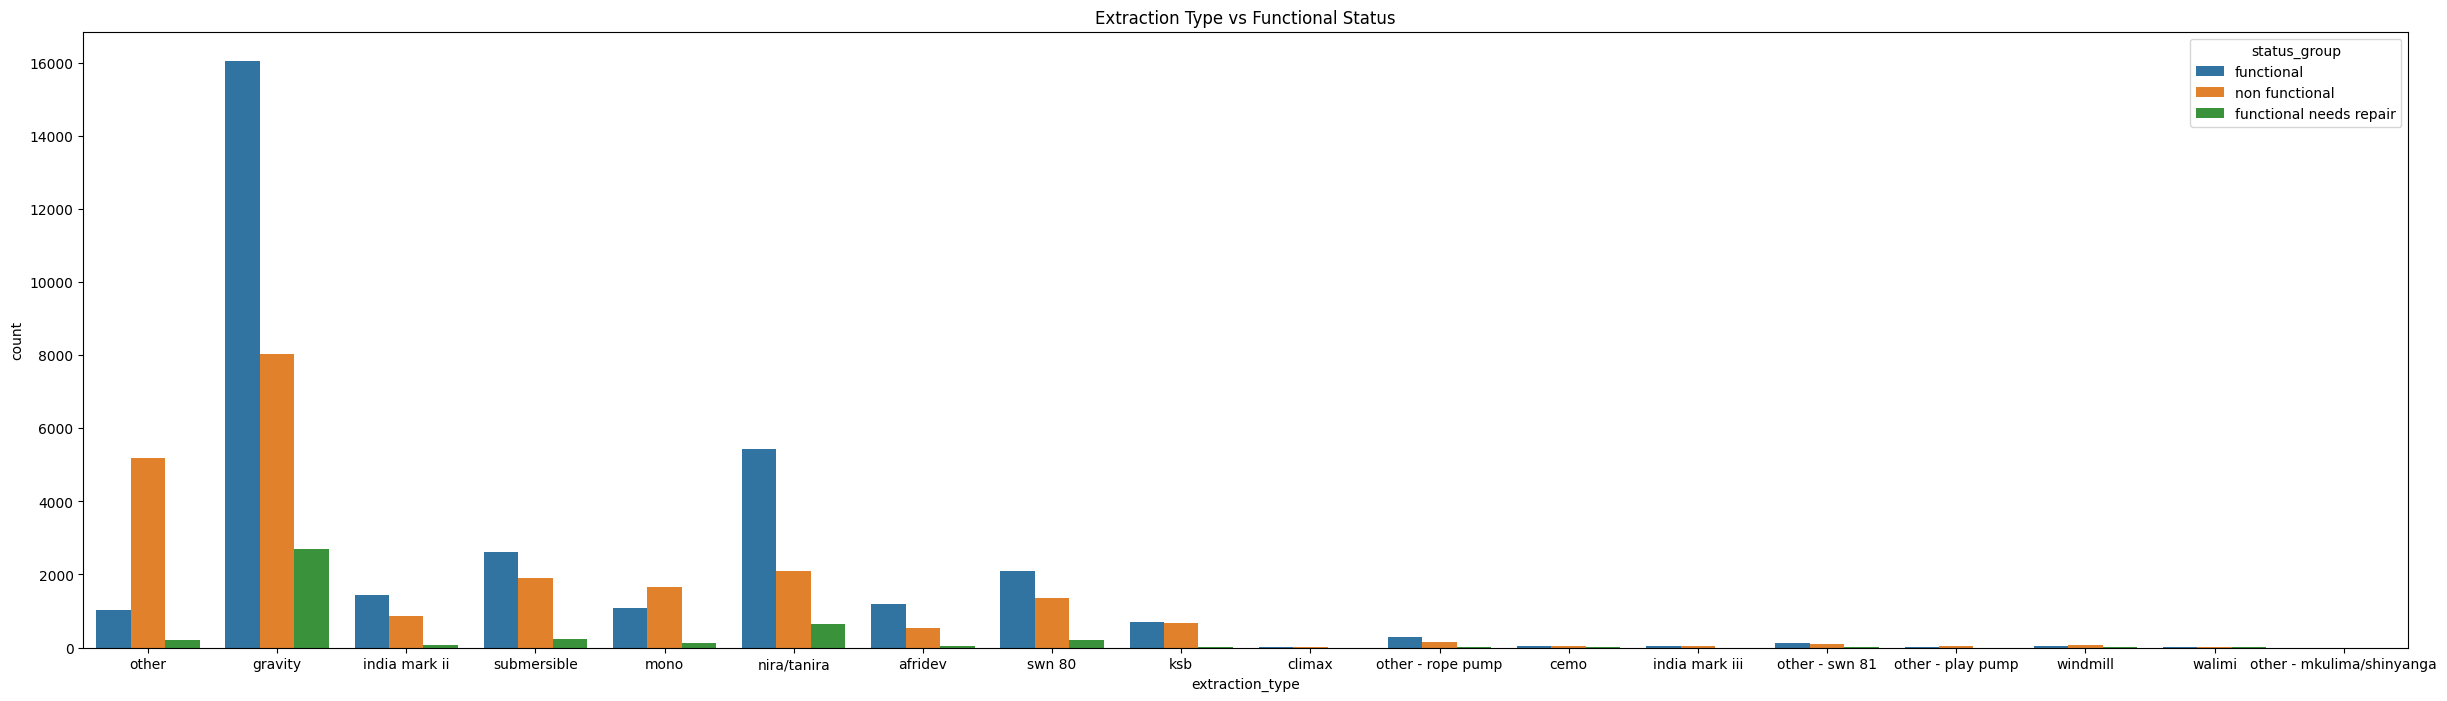

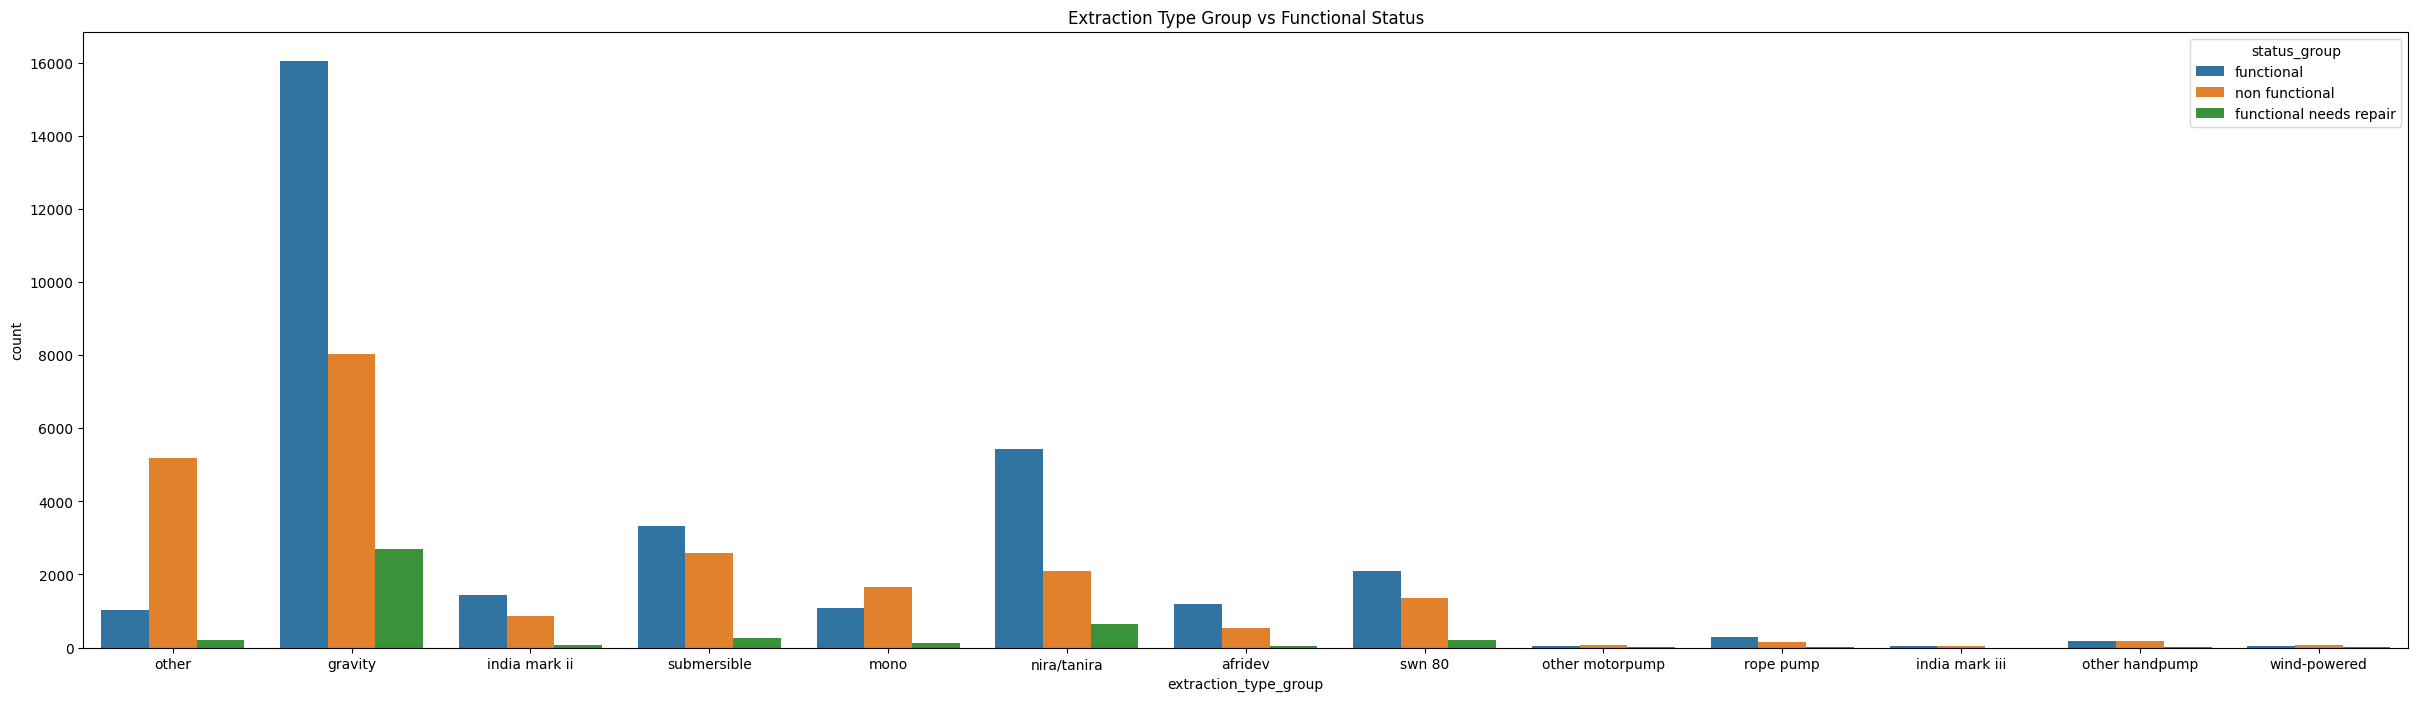

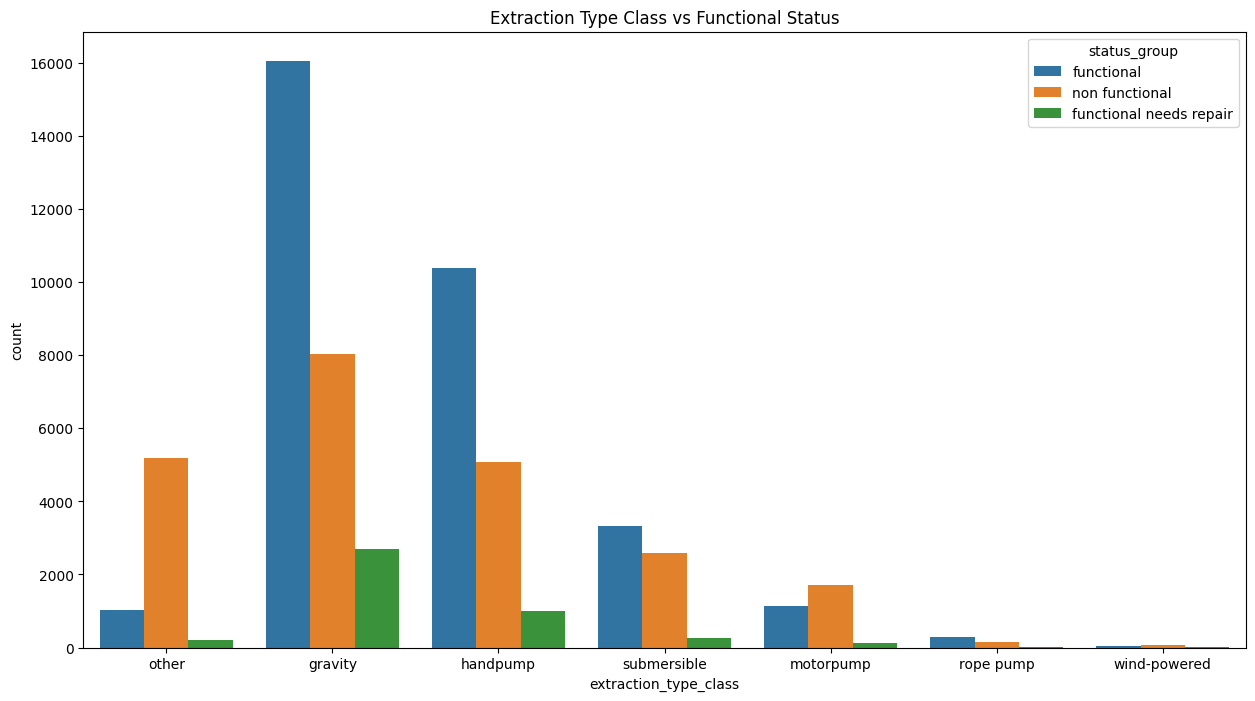

In [801]:
# Visualize extraction type vs status_group
plt.figure(figsize=(30,8))
sns.countplot(x='extraction_type', hue='status_group', data=All_data)
plt.title('Extraction Type vs Functional Status')
plt.show()

# Visualize extraction_type_group vs status_group
plt.figure(figsize=(30,8))
sns.countplot(x='extraction_type_group', hue='status_group', data=All_data)
plt.title('Extraction Type Group vs Functional Status')
plt.show()

# Visualize extraction type class vs status_group
plt.figure(figsize=(15,8))
sns.countplot(x='extraction_type_class', hue='status_group', data=All_data)
plt.title('Extraction Type Class vs Functional Status')
plt.show()

In [802]:
All_data = All_data.drop(['extraction_type_group'], axis=1)

### 3.24, 25 extraction_type, extraction_type_class

In [803]:
# drop extraction_type_class
All_data = All_data.drop(['extraction_type_class'], axis=1)

In [804]:
# Do one hot encoding
one_hot_encoded_data = pd.get_dummies(All_data, columns=['extraction_type'])
All_data = pd.concat([one_hot_encoded_data, All_data],axis=1).drop(columns= 'extraction_type')

**<h3>4 Visualization<h3>**

**4.1 scheme_management, management, management_group**

In [805]:
# Create a count graph to see the impact of scheme_management on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='scheme_management', hue='status_group', data=All_data)
plt.title('Distribution of Scheme Management by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: If using all scalar values, you must pass an index

<Figure size 1400x700 with 0 Axes>

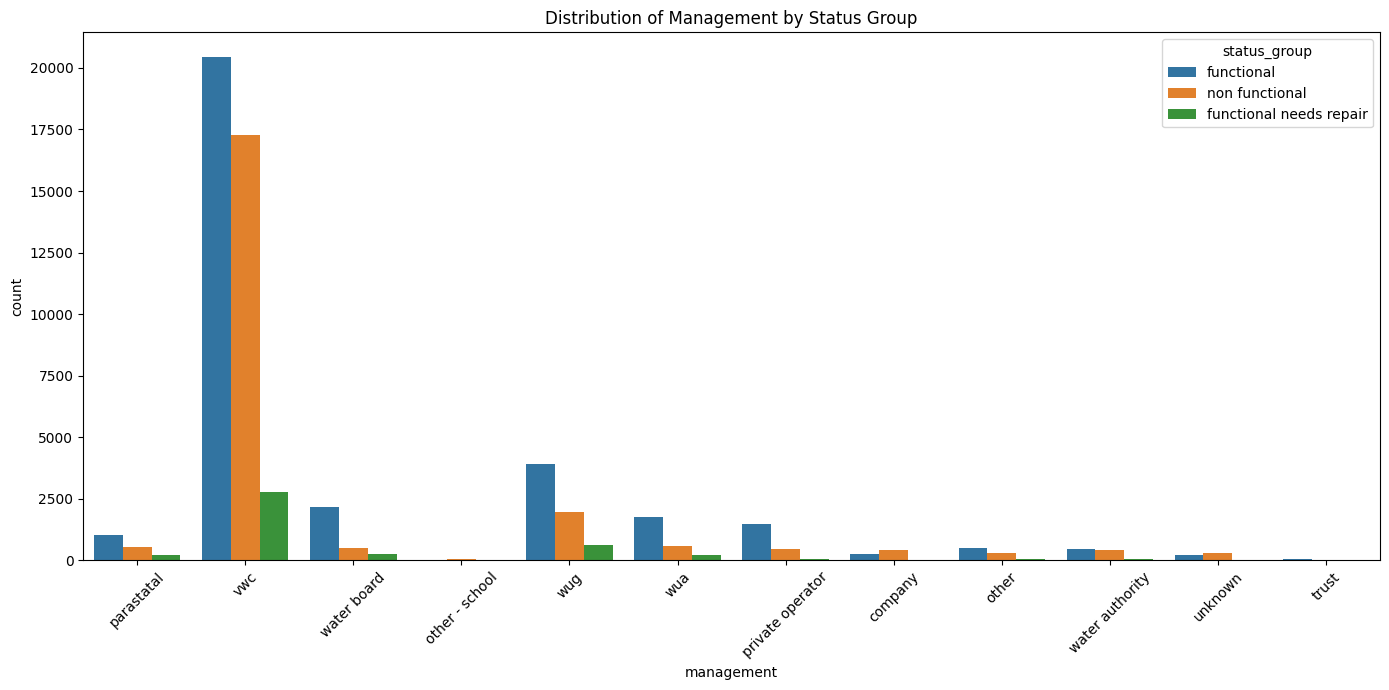

In [ ]:
# Create a count graph to see the impact of management on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='management', hue='status_group', data=All_data)
plt.title('Distribution of Management by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

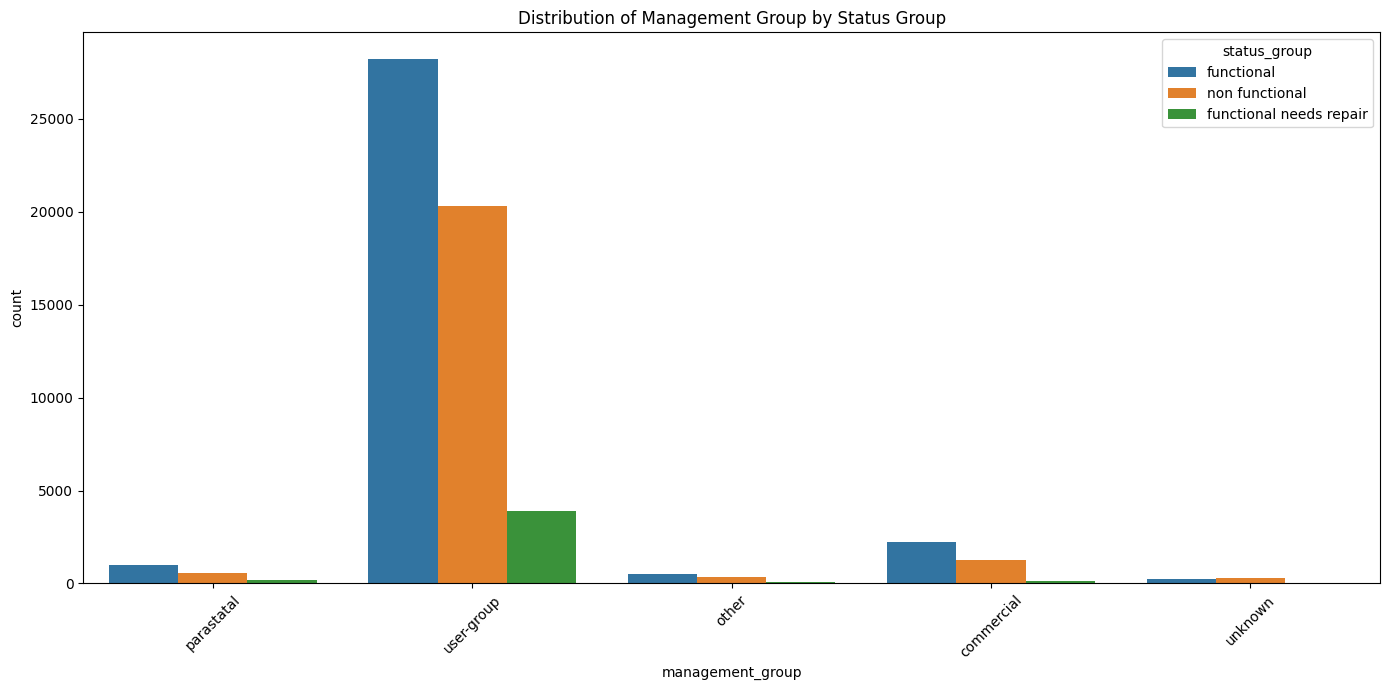

In [ ]:
# Create a count graph to see the impact of management_group on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='management_group', hue='status_group', data=All_data)
plt.title('Distribution of Management Group by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

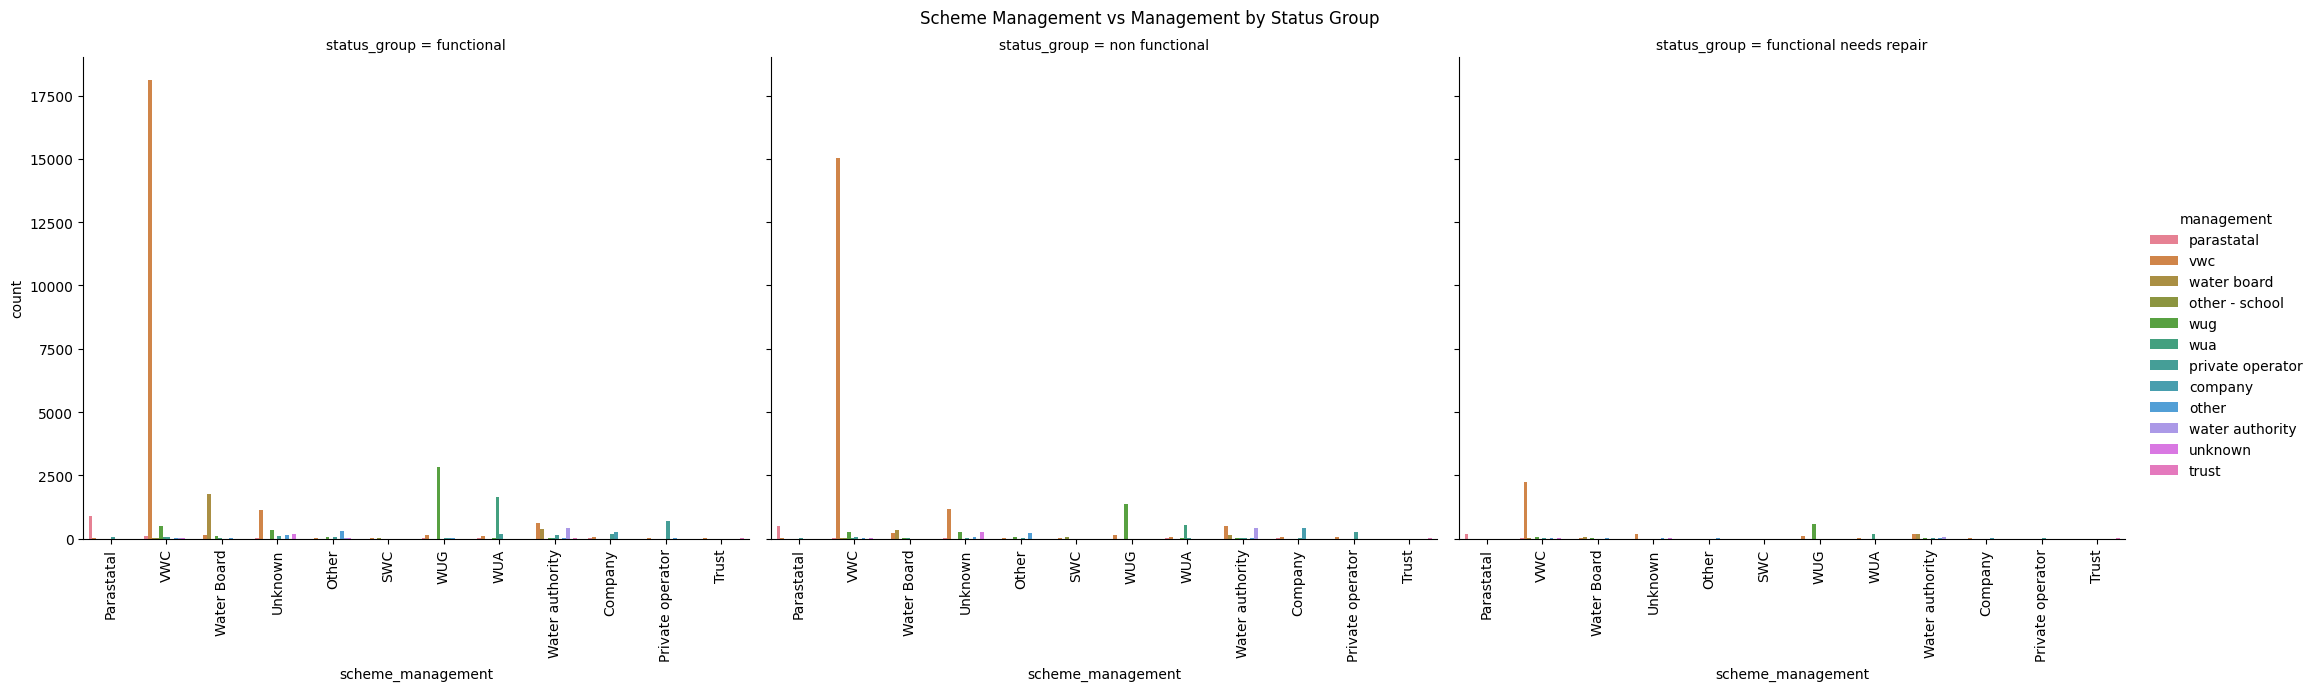

<Figure size 1600x1000 with 0 Axes>

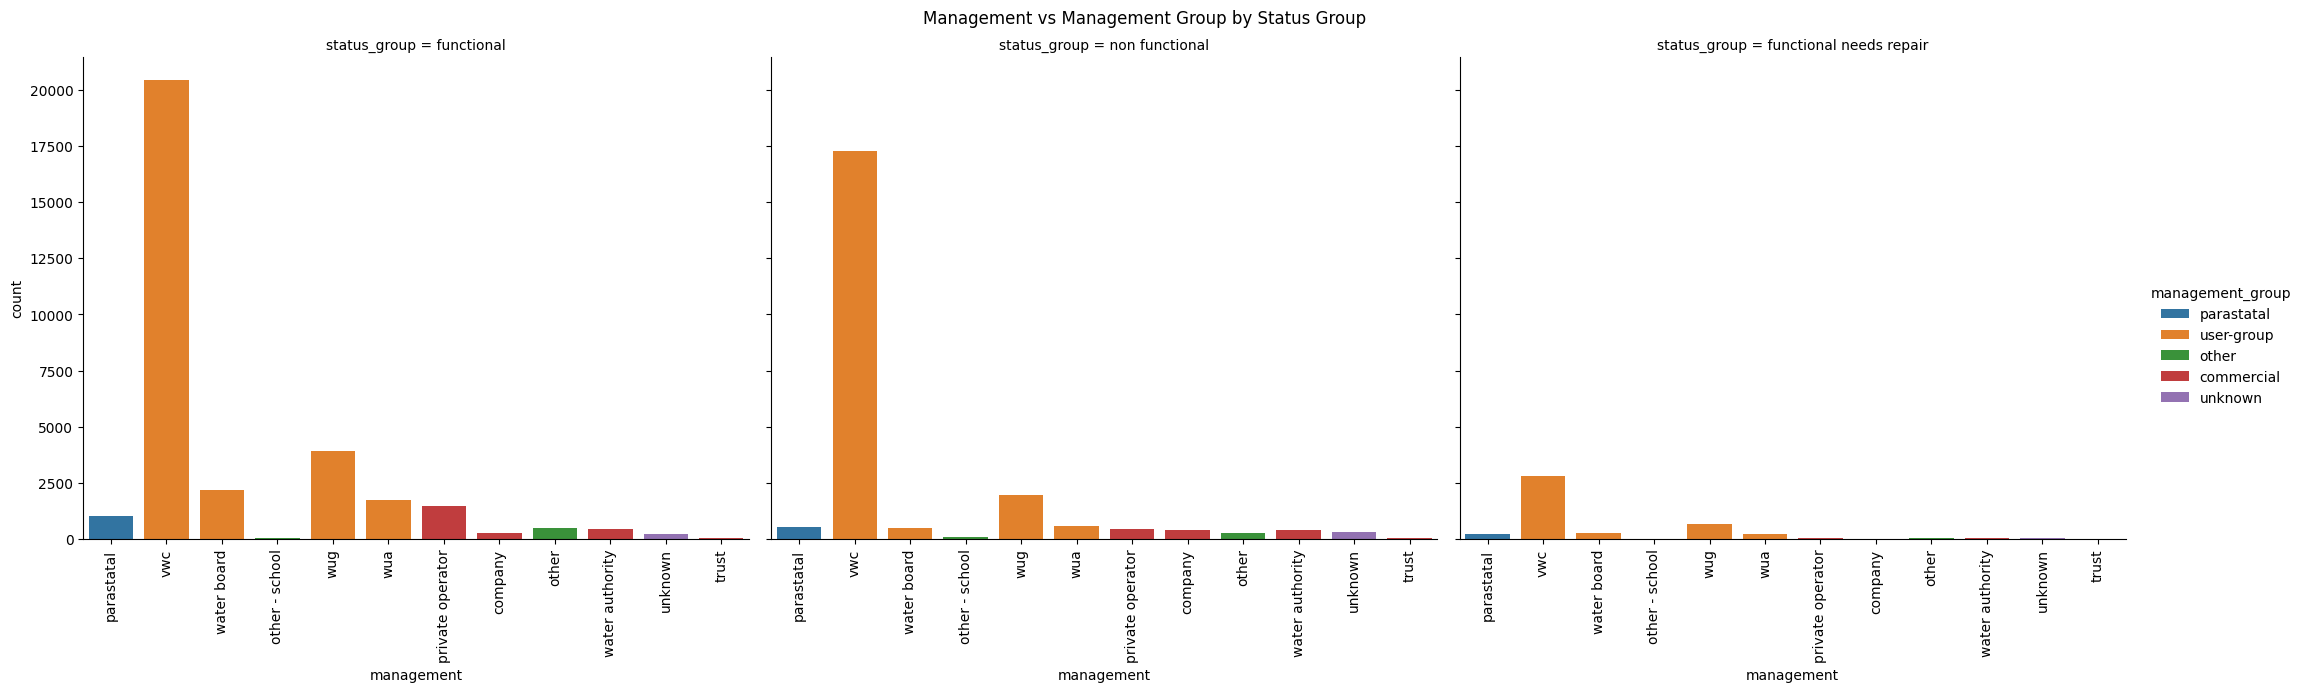

<Figure size 1600x1000 with 0 Axes>

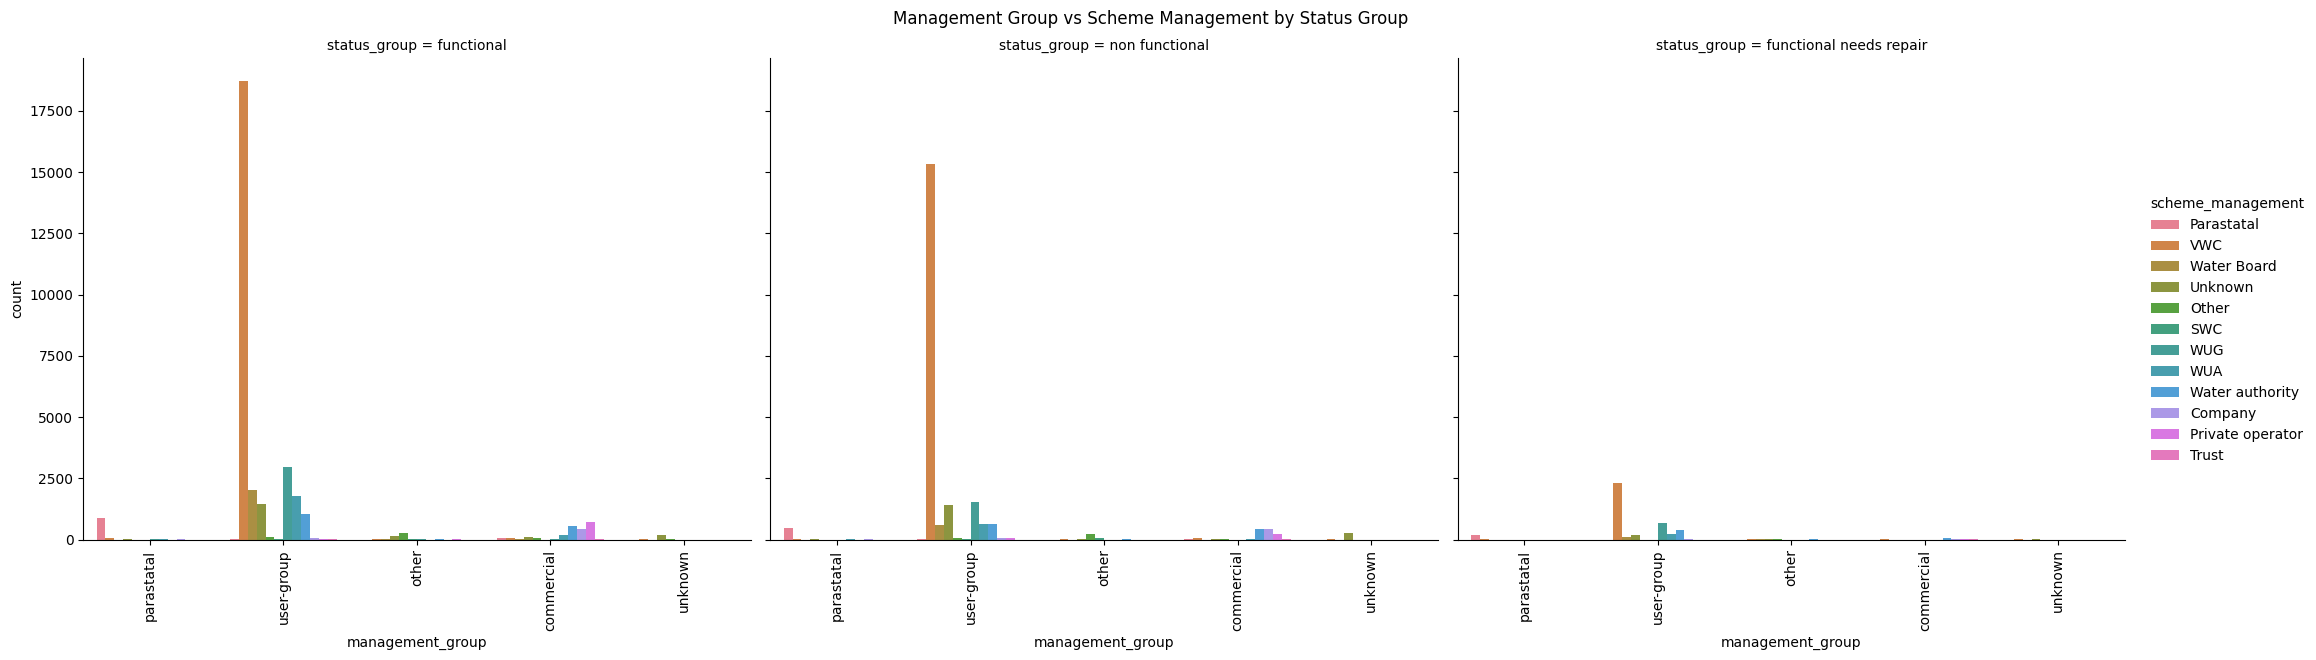

In [ ]:
# scheme_management and management
plt.figure(figsize=(16, 10))
g = sns.catplot(x="scheme_management", hue="management", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scheme Management vs Management by Status Group')
plt.show()

# management and management_group
plt.figure(figsize=(16, 10))
g = sns.catplot(x="management", hue="management_group", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Management vs Management Group by Status Group')
plt.show()

# management_group and scheme_management
plt.figure(figsize=(16, 10))
g = sns.catplot(x="management_group", hue="scheme_management", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Management Group vs Scheme Management by Status Group')
plt.show()

Analyzing the bi-variate plots using combinations of `scheme_management`, `management`, and `management_group` in relation to `status_group`, here’s a breakdown of insights and a suggestion on which variable might be the most redundant:

### Analysis of Plots:

1. **Scheme Management vs Management**:
   - This plot shows significant differentiation between different `scheme_management` categories and their associated `management` styles. Each management scheme, such as Parastatal, WUG, and Water Board, tends to have varied management types, indicating unique combinations that likely offer distinct insights.

2. **Management vs Management Group**:
   - There seems to be a substantial overlap in categories. For instance, most `management` categories like WUA, WUG, and Water Board are dominated by a single `management_group`, often the user-group. This suggests that the `management_group` is a high-level categorization which does not differentiate as finely as `management`.

3. **Management Group vs Scheme Management**:
   - Similar to the above, there appears to be strong overlap in how `scheme_management` and `management_group` are distributed across different status groups. Most `scheme_management` categories are predominantly associated with specific `management_group` categories, indicating redundancy.

### Conclusion:

From these observations:
- **Scheme Management vs Management** shows rich and varied combinations, which can provide deeper insights into how different management schemes and operational methods impact the functionality of water points.
- **Management vs Management Group** and **Management Group vs Scheme Management** both exhibit a high degree of overlap, suggesting redundancy between `management_group` and the other two variables.

### Suggested Variable to Remove:

- **`management_group`** appears to be the most appropriate variable to remove. It is less granular and its information seems largely encapsulated within both `scheme_management` and `management`. Removing `management_group` would likely retain most of the detailed insights provided by the finer distinctions within `management` and `scheme_management`.

Removing `management_group` should simplify the model or analysis without significant loss of information, as the more detailed variables (`management` and `scheme_management`) provide richer and more actionable insights into the operational status of water points. This approach should help in streamlining the analysis while preserving essential information for decision-making.

In [ ]:
# Creating Crosstabs: Scheme Management vs Management
ct_scheme_management = pd.crosstab(All_data['scheme_management'], All_data['management'])

# Creating Crosstabs：Management vs Management Group
ct_management_mgmtgroup = pd.crosstab(All_data['management'], All_data['management_group'])

# Creating Crosstabs：Management Group vs Scheme Management
ct_mgmtgroup_scheme = pd.crosstab(All_data['management_group'], All_data['scheme_management'])


In [ ]:
# Normalized Crosstab
ct_scheme_management_normalized = ct_scheme_management.div(ct_scheme_management.sum(axis=1), axis=0)
ct_management_mgmtgroup_normalized = ct_management_mgmtgroup.div(ct_management_mgmtgroup.sum(axis=1), axis=0)
ct_mgmtgroup_scheme_normalized = ct_mgmtgroup_scheme.div(ct_mgmtgroup_scheme.sum(axis=1), axis=0)

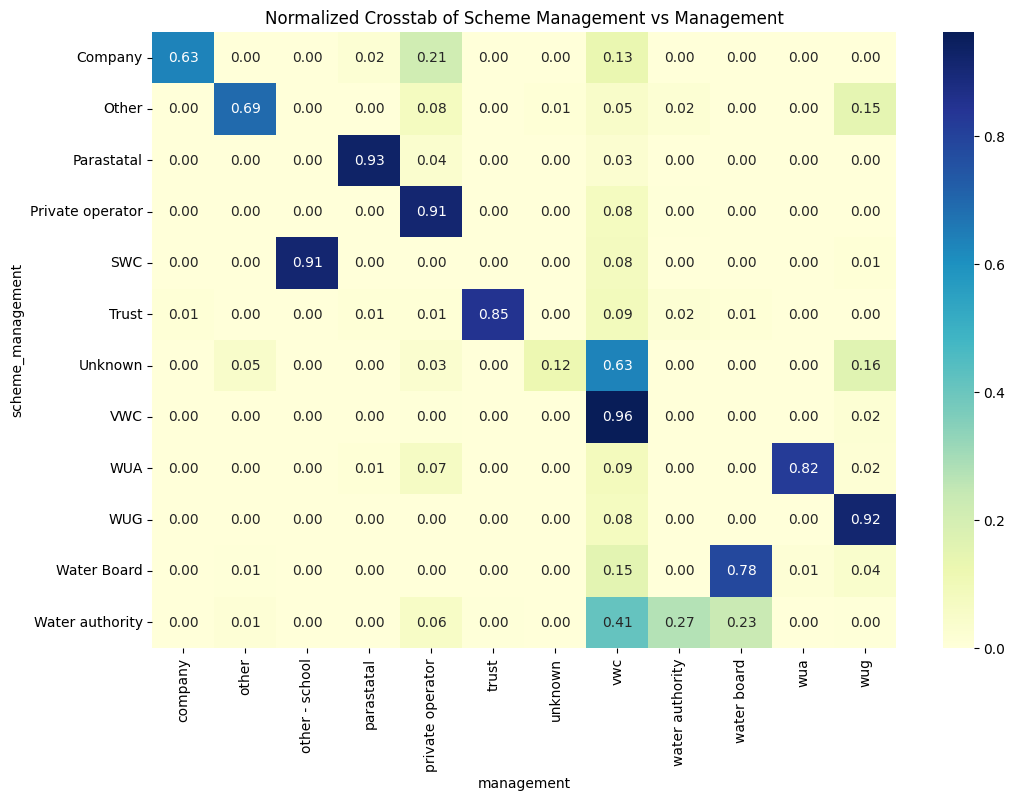

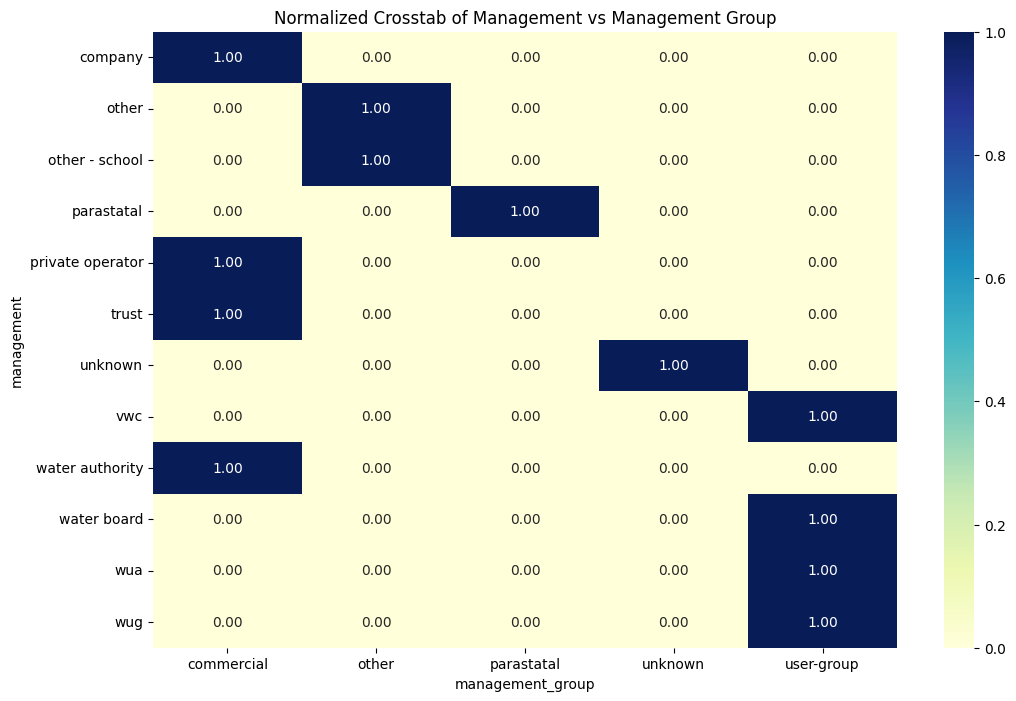

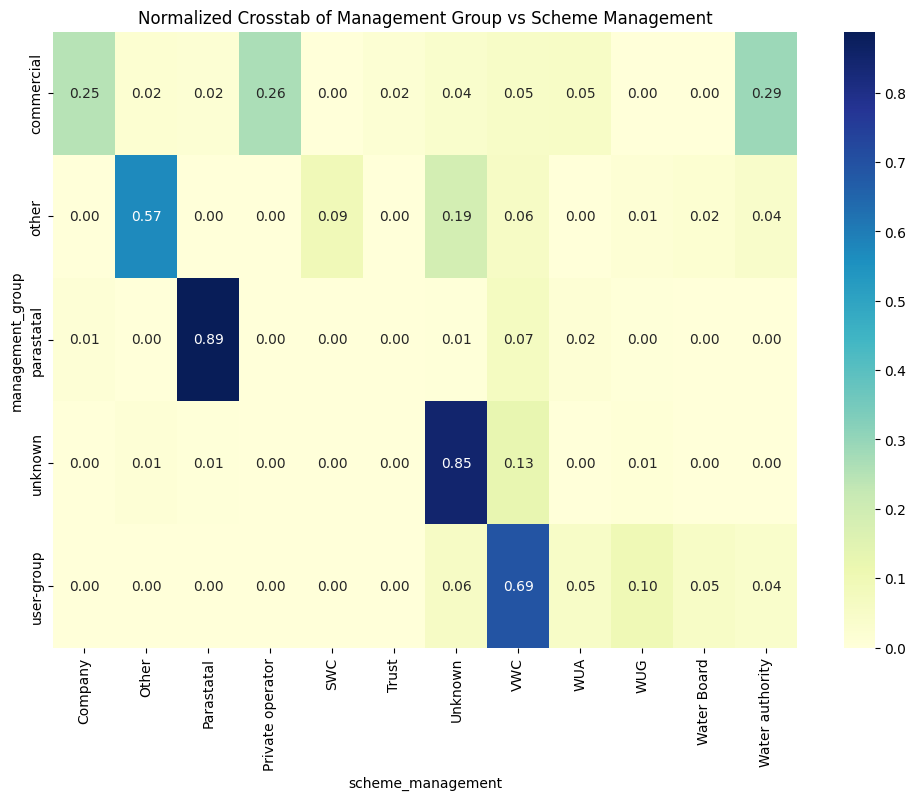

In [ ]:
# Visualize Scheme Management vs Management
plt.figure(figsize=(12, 8))
sns.heatmap(ct_scheme_management_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Scheme Management vs Management')
plt.show()

# Visualize Management vs Management Group
plt.figure(figsize=(12, 8))
sns.heatmap(ct_management_mgmtgroup_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Management vs Management Group')
plt.show()

# Visualize Management Group vs Scheme Management
plt.figure(figsize=(12, 8))
sns.heatmap(ct_mgmtgroup_scheme_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Management Group vs Scheme Management')
plt.show()

### 1. Scheme Management vs Management

This chart shows the distribution between **Scheme Management** categories and **Management** categories. Observations reveal:

- Specific management schemes, such as Parastatal, SWC, Trust, Unknown, WUA, WUG, and Water Board, are highly correlated with specific management types, for example, Parastatal mostly aligns with Parastatal management type, while WUA and WUG are closely linked with the user-group.
- While each **Scheme Management** category has distinct tendencies towards certain **Management** categories, they still retain unique information. Therefore, both variables provide valuable, high-resolution data.

### 2. Management vs Management Group

This chart illustrates the relationship between **Management** and **Management Group**. The results show:

- Most management types correspond almost exclusively with a single management group, such as company, private operator, trust, water authority closely related to commercial, parastatal, etc.
- Because the relationship between **Management** and **Management Group** is very significant (almost a one-to-one correspondence), this suggests that at least one of the two variables is redundant because one variable almost perfectly predicts the value of the other.
- This indicates that **Management Group** essentially serves as a simplified or aggregated version of **Management**, with **Management** offering more granular information than **Management Group**.

### 3. Management Group vs Scheme Management

This chart shows the relationship between **Management Group** and **Scheme Management**. The findings demonstrate:

- Certain management groups are highly associated with specific management schemes, such as the user-group predominantly associated with WUG and WUA schemes, and parastatal with the Parastatal scheme.
- While there are evident associations, the relationship between management schemes and management groups is not as direct as between management types.

### Suggested Variable for Removal

Given the high overlap between **Management** and **Management Group**, where **Management** provides more detailed information and **Management Group** acts more like an abstract category, it is advisable to remove **Management Group**. Doing so will reduce redundancy in the data while retaining more specific management information which is beneficial for deeper analysis.

Removing **Management Group** also means keeping more detailed and informative **Scheme Management** and **Management** in the data model, which will help provide more precise management insights, advantageous for formulating or improving management strategies.

In [ ]:
# Drop 'management_group' column
All_data.drop('management_group', axis=1, inplace=True)

In [ ]:
# One Hot encoding
All_data = pd.get_dummies(All_data, columns=['scheme_management'], dtype='int_')
All_data.head()

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... scheme_management_Parastatal scheme_management_Private operator  \
0  ...            

In [ ]:
All_data.head(2)

,id,amount_tsh,date_recorded,funder,installer,subvillage,region,region_code,district_code,lga,...,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Magoma,Manyara,21,3,Mbulu,...,0,0,1,0,0,0,0,0,0,1
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,Arusha,2,2,Arusha Rural,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Print a list of all column names
print(All_data.columns)


Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Company', 'scheme_management_Other',
       'scheme_management_Parastatal', 'scheme_management_Private operator',
       'scheme_management_SWC', 'scheme_management_Trust',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUA', 'scheme_management_WUG',
       'scheme_management_Water Board', 'schem

In [ ]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'scheme_management_Company')
calculate_zero_percentage(All_data, 'scheme_management_Other')
calculate_zero_percentage(All_data, 'scheme_management_Parastatal')
calculate_zero_percentage(All_data, 'scheme_management_Private operator')
calculate_zero_percentage(All_data, 'scheme_management_SWC')
calculate_zero_percentage(All_data, 'scheme_management_Trust')
calculate_zero_percentage(All_data, 'scheme_management_Unknown')
calculate_zero_percentage(All_data, 'scheme_management_VWC')
calculate_zero_percentage(All_data, 'scheme_management_WUA')
calculate_zero_percentage(All_data, 'scheme_management_WUG')
calculate_zero_percentage(All_data, 'scheme_management_Water Board')
calculate_zero_percentage(All_data, 'scheme_management_Water authority')

Percentage of 0s for scheme_management_Company: 98.19%
Percentage of 0s for scheme_management_Other: 98.66%
Percentage of 0s for scheme_management_Parastatal: 97.14%
Percentage of 0s for scheme_management_Private operator: 98.21%
Percentage of 0s for scheme_management_SWC: 99.83%
Percentage of 0s for scheme_management_Trust: 99.88%
Percentage of 0s for scheme_management_Unknown: 93.47%
Percentage of 0s for scheme_management_VWC: 38.16%
Percentage of 0s for scheme_management_WUA: 95.22%
Percentage of 0s for scheme_management_WUG: 91.25%
Percentage of 0s for scheme_management_Water Board: 95.34%
Percentage of 0s for scheme_management_Water authority: 94.65%


In [ ]:
# Drop colunms that percentage of 0 is over 95%
All_data.drop('scheme_management_Company', axis=1, inplace=True)
All_data.drop('scheme_management_Other', axis=1, inplace=True)
All_data.drop('scheme_management_Parastatal', axis=1, inplace=True)
All_data.drop('scheme_management_Private operator', axis=1, inplace=True)
All_data.drop('scheme_management_SWC', axis=1, inplace=True)
All_data.drop('scheme_management_Trust', axis=1, inplace=True)
All_data.drop('scheme_management_WUA', axis=1, inplace=True)
All_data.drop('scheme_management_Water Board', axis=1, inplace=True)

In [ ]:
# One Hot encoding
All_data = pd.get_dummies(All_data, columns=['management'], dtype='int_')
print(All_data.head())

KeyError: "None of [Index(['management'], dtype='object')] are in the [columns]"

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_company', 'management_other', 'management_other - school',
       'management_parastatal', 'management_private operator',
       'management_trust', 'management_unknown', 'management_vwc',
       'management_water authority', 'm

In [ ]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'management_company')
calculate_zero_percentage(All_data, 'management_other')
calculate_zero_percentage(All_data, 'management_other - school')
calculate_zero_percentage(All_data, 'management_parastatal')
calculate_zero_percentage(All_data, 'management_private operator')
calculate_zero_percentage(All_data, 'management_trust')
calculate_zero_percentage(All_data, 'management_unknown')
calculate_zero_percentage(All_data, 'management_vwc')
calculate_zero_percentage(All_data, 'management_water authority')
calculate_zero_percentage(All_data, 'management_water board')
calculate_zero_percentage(All_data, 'management_wua')
calculate_zero_percentage(All_data, 'management_wug')

Percentage of 0s for management_company: 98.84%
Percentage of 0s for management_other: 98.54%
Percentage of 0s for management_other - school: 99.83%
Percentage of 0s for management_parastatal: 97.00%
Percentage of 0s for management_private operator: 96.63%
Percentage of 0s for management_trust: 99.86%
Percentage of 0s for management_unknown: 99.08%
Percentage of 0s for management_vwc: 31.82%
Percentage of 0s for management_water authority: 98.49%
Percentage of 0s for management_water board: 95.03%
Percentage of 0s for management_wua: 95.80%
Percentage of 0s for management_wug: 89.08%


In [ ]:
# Drop colunms that percentage of 0 is over 95%. But keep the 'management_water board' and 'management_wua', since the percentage is close to 95%.
All_data.drop('management_company', axis=1, inplace=True)
All_data.drop('management_other', axis=1, inplace=True)
All_data.drop('management_other - school', axis=1, inplace=True)
All_data.drop('management_parastatal', axis=1, inplace=True)
All_data.drop('management_private operator', axis=1, inplace=True)
All_data.drop('management_trust', axis=1, inplace=True)
All_data.drop('management_unknown', axis=1, inplace=True)
All_data.drop('management_water authority', axis=1, inplace=True)

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug'],
      dtype='object')


**4.2 water_quality, quality_group**

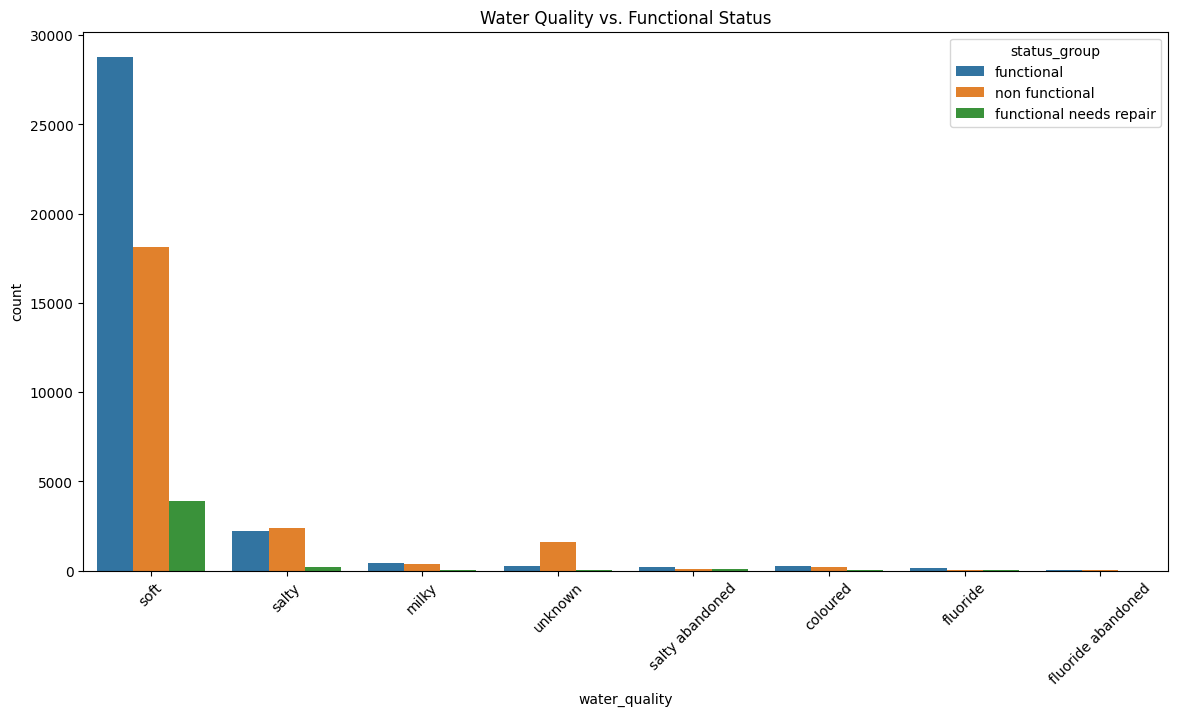

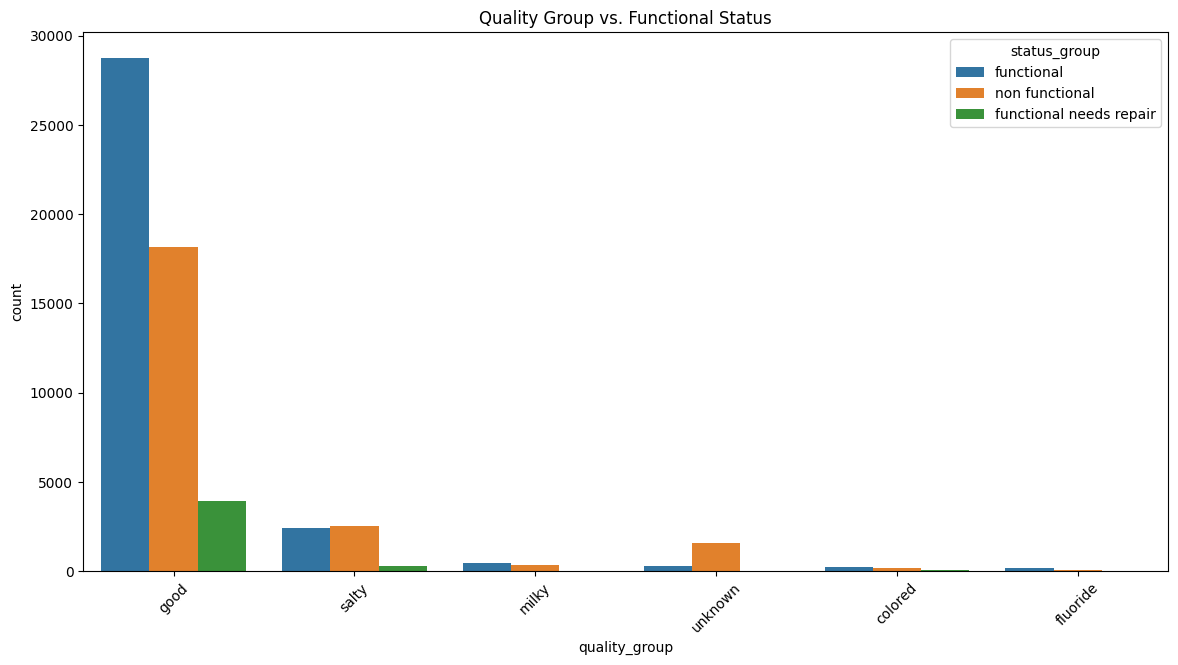

In [ ]:
subset = All_data[['water_quality', 'quality_group', 'status_group']]

# Visualize water_quality vs status_group
plt.figure(figsize=(14, 7))
sns.countplot(data=subset, x='water_quality', hue='status_group')
plt.title('Water Quality vs. Functional Status')
plt.xticks(rotation=45)
plt.show()

# Visualize quality_group vs status_group
plt.figure(figsize=(14, 7))
sns.countplot(data=subset, x='quality_group', hue='status_group')
plt.title('Quality Group vs. Functional Status')
plt.xticks(rotation=45)
plt.show()

From the two visualizations you provided, we can observe the following:

**Water Quality** vs. **Functional Status**:

The **water_quality** variable provides a more detailed classification of water quality, and the distribution of each classification under different functional states (good function, non-functional, and needing repair). For example, soft water quality occupies most of the water points with good function, while other types such as salty and milky also have a certain distribution in the non-functional or needing repair states. 

**Water Quality Group vs. Functional Status**:

The classification of **quality_group** is broader, including good, salty, milky, etc. Although it can reflect the relationship with the functional status, its information is less detailed than water_quality. 


**Analysis suggestions**:

**water_quality** provides more details and may be more useful. For example, knowing clearly whether the water is salty or salty abandoned may be crucial for some analysis or decision-making. 

If the purpose of the project is to identify general categories of water quality and does not require very detailed classification, **quality_group** is sufficient to meet the needs while also simplifying the complexity of the model. 

Conclusion:
In these two figures, although **water_quality** provides more details, the information of **quality_group** is enough to reflect the impact of water quality on functional status in most cases. Therefore, keeping **quality_group** may be a more reasonable choice. This can simplify the dataset while maintaining important information about the functional status of water points.

In [ ]:
# Drop the 'water_quality' colunm
All_data.drop(columns=['water_quality'], inplace=True)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quality_group'], dtype='int_')
print(All_data.head(2))

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... payment_type_never pay payment_type_on failure payment_type_per bucket  \
0  ...     

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown',
       'quality_group_colored', 'quality_group_fluorid

In [ ]:
def calculate_zero_percentage(df,list_of_col, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")
    

calculate_zero_percentage(All_data, 'quality_group_colored')
calculate_zero_percentage(All_data, 'quality_group_fluoride')
calculate_zero_percentage(All_data, 'quality_group_good')
calculate_zero_percentage(All_data, 'quality_group_milky')
calculate_zero_percentage(All_data, 'quality_group_salty')
calculate_zero_percentage(All_data, 'quality_group_unknown')

Percentage of 0s for quality_group_colored: 99.16%
Percentage of 0s for quality_group_fluoride: 99.64%
Percentage of 0s for quality_group_good: 14.47%
Percentage of 0s for quality_group_milky: 98.65%
Percentage of 0s for quality_group_salty: 91.24%
Percentage of 0s for quality_group_unknown: 96.84%


In [ ]:
# Drop colunms that percentage of 0 is over 99%.
All_data = All_data.drop('quality_group_colored', axis=1, inplace=True)
All_data.drop('quality_group_fluoride', axis=1, inplace=True)

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'q

**4.3 source, source_type, source_class**

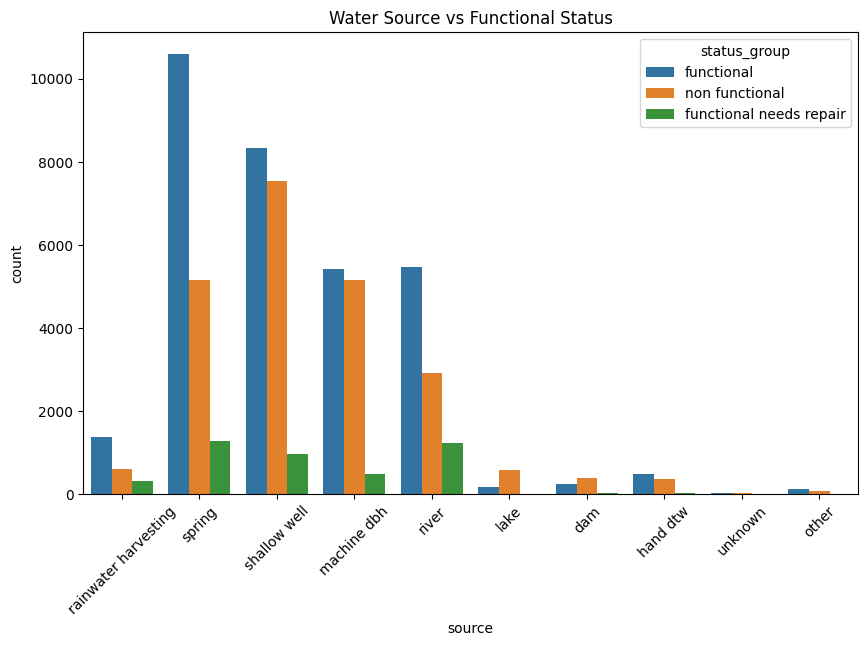

Chi-squared: 2623.998280150263, p-value: 0.0


In [ ]:
from scipy.stats import chi2_contingency
# Visualize source vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source', hue='status_group', data=All_data)
plt.title('Water Source vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test example for 'source'
contingency_table = pd.crosstab(All_data['source'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")


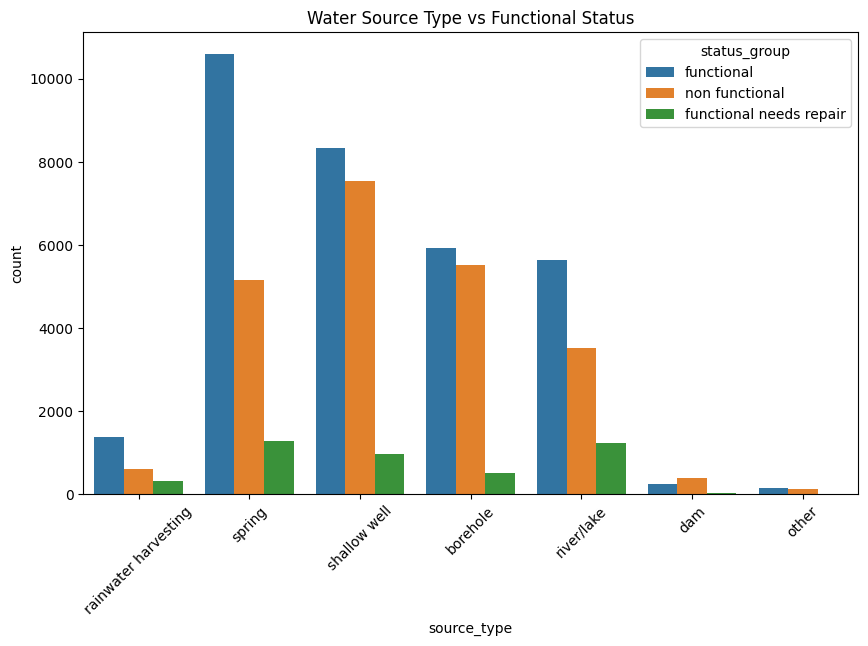

Chi-squared: 1906.7974141394534, p-value: 0.0


In [ ]:
# Visualize source_type vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source_type', hue='status_group', data=All_data)
plt.title('Water Source Type vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_type'
contingency_table = pd.crosstab(All_data['source_type'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

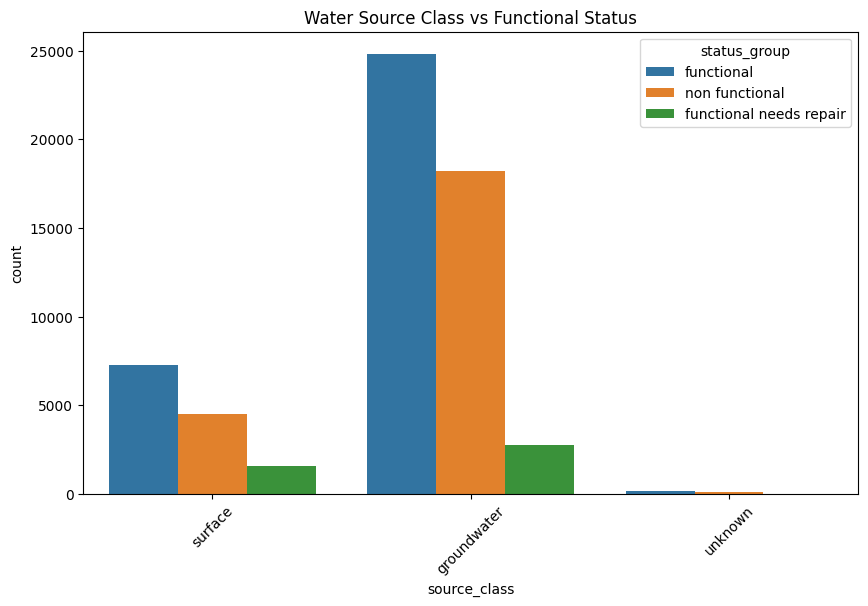

Chi-squared: 590.263287271222, p-value: 1.983538119535751e-126


In [ ]:
# Visualize source_class vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source_class', hue='status_group', data=All_data)
plt.title('Water Source Class vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_class'
contingency_table = pd.crosstab(All_data['source_class'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

Based on the analysis I've conducted, it seems that the `source`, `source_type`, and `source_class` variables provide different levels of granularity about the source of water:

1. **Source** provides specific details such as 'spring', 'shallow well', etc., which are very granular and directly related to the physical source of the water.
2. **Source Type** is a slightly aggregated version of the `source` variable, combining closely related sources into groups like 'river/lake' or 'borehole'.
3. **Source Class** is the most aggregated, categorizing sources simply into broader classes like 'groundwater' and 'surface'.

The visualizations and the chi-squared test results strongly suggest that all three variables are significantly related to the functional status of the water points. However, `source` and `source_type` provide more detailed breakdowns and show distinctions between different water sources more clearly than `source_class`.

Choosing `source_type` can simplify the model and reduce potential overfitting while retaining enough meaningful information. It reduces complexity without losing significant granularity, as evidenced by the detailed chi-squared test results and its capacity to still differentiate well between functional statuses.

In [ ]:
# Drop the 'source' and 'source_class' colunm
All_data.drop(columns=['source'], inplace=True)
All_data.drop(columns=['source_class'], inplace=True)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['source_type'] ,dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... quantity_insufficient quantity_seasonal quantity_unknown  \
0  ...                   

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'scheme_management_Unknown',
       'scheme_management_VWC', 'scheme_management_WUG',
       'scheme_management_Water authority', 'management_vwc',
       'management_water board', 'management_wua', 'management_wug',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity

In [ ]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'source_type_borehole')
calculate_zero_percentage(All_data, 'source_type_dam')
calculate_zero_percentage(All_data, 'source_type_other')
calculate_zero_percentage(All_data, 'source_type_rainwater harvesting')
calculate_zero_percentage(All_data, 'source_type_river/lake')
calculate_zero_percentage(All_data, 'source_type_shallow well')
calculate_zero_percentage(All_data, 'source_type_spring')

Percentage of 0s for source_type_borehole: 79.89%
Percentage of 0s for source_type_dam: 98.87%
Percentage of 0s for source_type_other: 99.53%
Percentage of 0s for source_type_rainwater harvesting: 96.14%
Percentage of 0s for source_type_river/lake: 82.61%
Percentage of 0s for source_type_shallow well: 71.53%
Percentage of 0s for source_type_spring: 71.43%


In [ ]:
# Drop 'source_type_other' colunm
All_data.drop(columns=['source_type_other'], inplace=True)

In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'scheme_management_Unknown',
       'scheme_management_VWC', 'scheme_management_WUG',
       'scheme_management_Water authority', 'management_vwc',
       'management_water board', 'management_wua', 'management_wug',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity

**4.4 waterpoint_type, waterpoint_type_group**

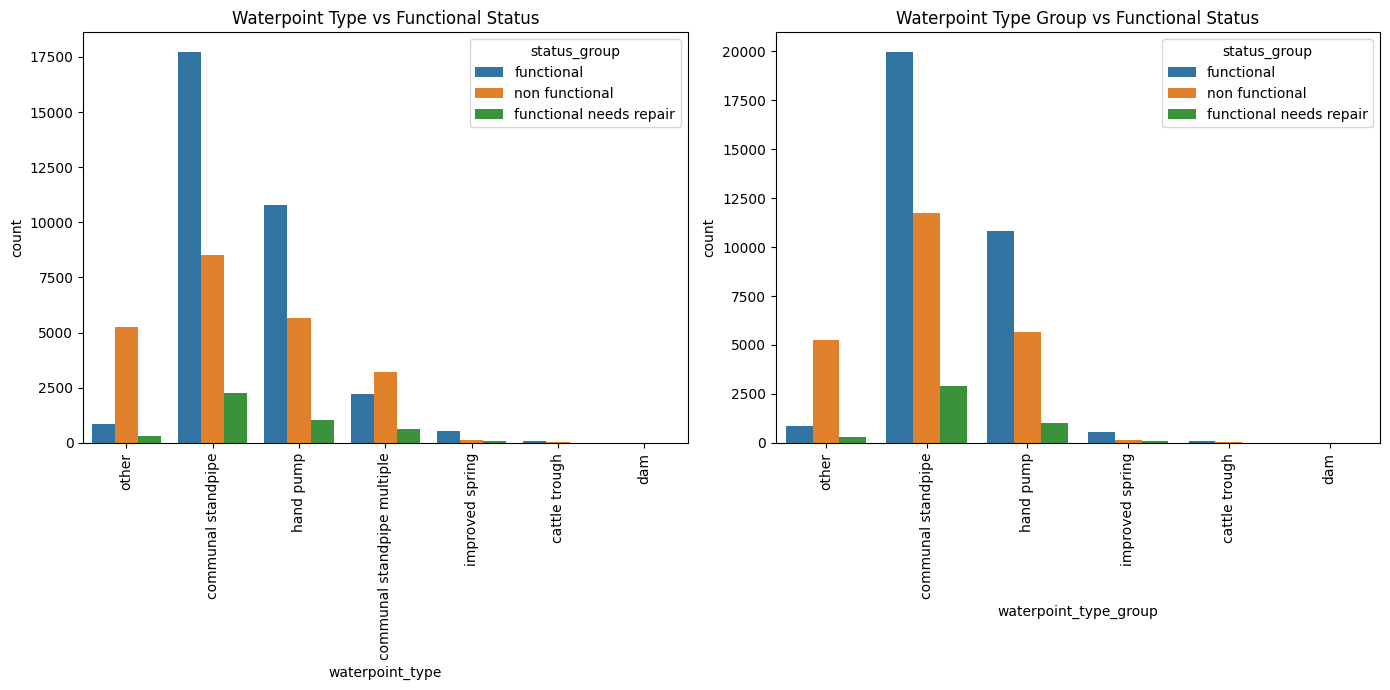

In [ ]:
plt.figure(figsize=(14, 7))

# Waterpoint Type vs. Functional Status
plt.subplot(1, 2, 1)
sns.countplot(data=All_data, x='waterpoint_type', hue='status_group')
plt.title('Waterpoint Type vs Functional Status')
plt.xticks(rotation=90)

# Waterpoint Type Group vs. Functional Status
plt.subplot(1, 2, 2)
sns.countplot(data=All_data, x='waterpoint_type_group', hue='status_group')
plt.title('Waterpoint Type Group vs Functional Status')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Based on the visualizations, retaining the `waterpoint_type` variable would be the better choice. This is because `waterpoint_type` offers a more detailed categorization of the water sources, which provides a finer granularity in the analysis of the relationship between the type of waterpoint and its functional status. 

The granularity of `waterpoint_type` allows for more nuanced insights and decision-making regarding maintenance needs and functionality improvements specific to each type. For example, understanding the specific needs of hand pumps versus communal standpipes can direct targeted interventions that are more likely to improve functionality and longevity of the water sources.

Furthermore, the detailed breakdown in `waterpoint_type` enhances the ability to track performance and issues at a more granular level, which is critical for effective water resource management and planning. This can help in prioritizing which types need more attention or which are performing well under current conditions, thus contributing to better resource allocation and policy-making.

In [ ]:
# Drop the 'waterpoint_type_group' colunm
All_data.drop(columns=['waterpoint_type_group'], inplace=True)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['waterpoint_type'], dtype='int_')
print(All_data.head(2))

In [ ]:
All_data.head(2)

,id,amount_tsh,date_recorded,funder,installer,subvillage,region,region_code,district_code,lga,...,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Magoma,Manyara,21,3,Mbulu,...,0,0,1,0,0,0,0,0,0,1
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,Arusha,2,2,Arusha Rural,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity

In [ ]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'waterpoint_type_cattle trough')
calculate_zero_percentage(All_data, 'waterpoint_type_communal standpipe')
calculate_zero_percentage(All_data, 'waterpoint_type_communal standpipe multiple')
calculate_zero_percentage(All_data, 'waterpoint_type_dam')
calculate_zero_percentage(All_data, 'waterpoint_type_hand pump')
calculate_zero_percentage(All_data, 'waterpoint_type_improved spring')
calculate_zero_percentage(All_data, 'waterpoint_type_other')

Percentage of 0s for waterpoint_type_cattle trough: 99.80%
Percentage of 0s for waterpoint_type_communal standpipe: 52.02%
Percentage of 0s for waterpoint_type_communal standpipe multiple: 89.75%
Percentage of 0s for waterpoint_type_dam: 99.99%
Percentage of 0s for waterpoint_type_hand pump: 70.53%
Percentage of 0s for waterpoint_type_improved spring: 98.71%
Percentage of 0s for waterpoint_type_other: 89.21%


In [ ]:
# Drop 'waterpoint_type_dam' and 'waterpoint_type_cattle trough' colunms
All_data.drop(columns=['waterpoint_type_cattle trough'], inplace=True)
All_data.drop(columns=['waterpoint_type_dam'], inplace=True)

**<h3>Save File<h3>**

In [ ]:
All_data.to_csv('Values_Modify.csv')